# **Universidad Nacional de Rosario - Facultad de Ciencias Exactas, Ingeniería y Agrimensura**

## Tecnicatura Universitaria en Inteligencia Artificial

### Procesamiento del Lenguaje Natural: Trabajo Práctico N°2

### **Julia Sumiacher: S-57932**



---



# Dependencias

In [1]:
!apt-get update
!apt-get install -y chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
!pip install selenium
!pip install langdetect
!pip install import os
!pip install tensorflow tensorflow-text
!pip install pydub
!pip install SpeechRecognition
!pip install PyPDF2
!pip install chromadb
!pip install python-decouple
!pip install deep-translator
!pip install rdflib
!python -m spacy download es_core_news_sm
!pip install llama-index-llms-ollama
!pip install wikipedia
!pip install --upgrade --quiet  wikipedia
!pip install langchain
!pip install litellm[proxy]
!pip install llama-index
!pip install rank-bm25
!pip install nltk
!apt-get update
!pip install langchain-community
!pip install langchain-huggingface
!pip install selenium webdriver-manager
!pip install webdriver-manager
!pip install langchain-huggingface
!pip install --upgrade transformers torch
!pip uninstall -y torch torchvision torchaudio
!pip install tools
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip install --upgrade langchain
!pip install langgraph

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

# Librerías

In [2]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.common.exceptions import TimeoutException
from transformers import AutoTokenizer
from sentence_transformers import CrossEncoder, SentenceTransformer, util
from rdflib import Graph, Namespace
from urllib.parse import unquote
from sklearn.metrics import confusion_matrix
from transformers import AutoModelForCausalLM, AutoTokenizer
from google.colab import userdata
from huggingface_hub import InferenceClient
from rdflib.namespace import FOAF, XSD
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import langchain
from langgraph.prebuilt import create_react_agent
from langchain.utilities import WikipediaAPIWrapper
import difflib
import re
import pickle
import tools
from langdetect import detect
import networkx as nx
import plotly.graph_objects as go
import numpy as np
import rdflib
import urllib.parse
from rdflib import Graph, Namespace, Literal
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import sentencepiece
from pydub import AudioSegment
import speech_recognition as sr
import os
from langchain.text_splitter import RecursiveCharacterTextSplitter
import PyPDF2
import chromadb
from chromadb.config import Settings
import requests
import json
from decouple import config, Config, Csv
from jinja2 import Template
import pandas as pd
from deep_translator import GoogleTranslator
from itertools import chain
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from huggingface_hub import InferenceClient
from typing import List, Dict, Any
import spacy
import wikipedia
from chromadb.config import Settings
from rank_bm25 import BM25Okapi
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
nltk.data.path.append('/root/nltk_data/tokenizers/punkt')
from typing import List, Dict, Any
import os
import gdown
import math
from rdflib import Graph
import ast
import pickle
from nltk.corpus import stopwords
import urllib.parse
import logging
import time

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# RAG

## Base de datos vectorial

In [3]:
# Cargar Universal Sentence Encoder
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3")

### Extraer información

In [4]:
def limpiar_texto(texto):
    """
    Descripción:
    La función `limpiar_texto` procesa una cadena de texto para eliminar caracteres no deseados,
    reducir espacios múltiples y conservar solo caracteres alfanuméricos, algunos signos de puntuación
    comunes y letras con acentos o diéresis.
    """
    # Eliminar secuencias de escape Unicode (\uXXXX y \xXX)
    texto = re.sub(r'\\u[0-9a-fA-F]{4}|\\x[0-9a-fA-F]{2}', '', texto)
    # Conservar caracteres alfanuméricos, espacios y signos de puntuación básicos (incluyendo letras con acentos)
    texto = re.sub(r'[^a-zA-Z0-9áéíóúüñÁÉÍÓÚÜÑ\s.,;!?()-]', '', texto)
    # Reducir espacios múltiples a uno solo
    texto = re.sub(r'\s+', ' ', texto)
    return texto.strip()

def extract_text_with_pypdf2(pdf_path):
    """
    Extrae texto de un PDF usando PyPDF2 y lo limpia con `limpiar_texto`
    """
    full_text = ""
    with open(pdf_path, "rb") as pdf_file:
        reader = PyPDF2.PdfReader(pdf_file)
        for page in reader.pages:
            text = page.extract_text()
            if text:
                text = limpiar_texto(text)
                full_text += text.replace("\n", " ") + " "
    return full_text

def split_into_sections_auto(full_text, titles):
    """
    Divide el texto en secciones basadas en títulos predefinidos.
    La búsqueda se realiza de forma insensible a mayúsculas para mayor robustez.
    """
    sections = {title: "" for title in titles}
    # Crear un patrón que combine todos los títulos (escapados) y lo compile con re.IGNORECASE
    pattern = re.compile("|".join(re.escape(title) for title in titles), re.IGNORECASE)

    # Encontrar todas las coincidencias (match) en el texto
    matches = list(pattern.finditer(full_text))

    if not matches:
        # Si no se encuentran títulos, se retorna el diccionario con secciones vacías
        return sections

    # Recorrer las coincidencias para extraer el contenido entre cada título
    for i, match in enumerate(matches):
        start_index = match.start()
        end_index = match.end()
        # Se obtiene el título detectado (el match puede diferir en mayúsculas/minúsculas)
        current_title = match.group()
        # Se busca el título original que coincida (ignorando mayúsculas)
        actual_title = None
        for title in titles:
            if title.lower() == current_title.lower():
                actual_title = title
                break
        if not actual_title:
            continue

        # El contenido de la sección se extiende desde el final del título actual hasta el inicio del siguiente
        section_text_start = end_index
        section_text_end = matches[i+1].start() if i+1 < len(matches) else len(full_text)
        sections[actual_title] = full_text[section_text_start:section_text_end].strip() + " "
    return sections

In [5]:
def extraer_texto(url):
    """
    Extrae y devuelve todo el texto presente en el cuerpo de una página web.

    Parámetros:
    -----------
    url : str
        La URL de la página web de la que se desea extraer el texto.

    Retorna:
    --------
    str
        Un string con todo el texto visible en la página web.
        Si ocurre un error, devuelve una cadena vacía ("").

    Funcionalidad:
    --------------
    1. Inicia un navegador Chrome en modo headless.
    2. Intenta acceder a la URL proporcionada.
    3. Si la página muestra un botón de cookies con la clase `.cky-btn-accept`, intenta cerrarlo.
    4. Espera hasta que el cuerpo de la página (`<body>`) esté completamente cargado.
    5. Extrae y devuelve el texto del cuerpo de la página.
    6. En caso de error, imprime el mensaje y devuelve una cadena vacía.
    7. Cierra el navegador al finalizar el proceso.

    """

    options = webdriver.ChromeOptions()
    options.add_argument("--headless")
    options.add_argument("--disable-gpu")
    options.add_argument("--no-sandbox")
    driver = webdriver.Chrome(options=options)

    try:
        driver.get(url)

        # Cerrar cookies
        try:
            WebDriverWait(driver, 3).until(
                EC.element_to_be_clickable((By.CSS_SELECTOR, ".cky-btn-accept"))
            ).click()
        except:
            pass

        # Esperar y extraer TODO el texto del cuerpo
        cuerpo = WebDriverWait(driver, 15).until(
            EC.presence_of_element_located((By.TAG_NAME, "body"))
        )

        # Extraer texto como string único
        texto_completo = cuerpo.text

        return texto_completo  # <- Esto es un string, NO una lista

    except Exception as e:
        print(f"Error: {str(e)}")
        return ""

    finally:
        driver.quit()


### Fuente: PDF "7 Wonders RULES"

In [6]:
# Lista de títulos que se esperan encontrar en el PDF
indices_manual = [
    'CONTENIDO',
    'DESARROLLO Y OBJETIVO DE LA PARTIDA',
    'ELEMENTOS DE LA PARTIDA',
    'PREPARACIÓN DE LA PARTIDA',
    'CONSTRUCCIÓN EN 7 WONDERS',
    'JUGANDO UNA PARTIDA',
    'FINAL DE LA PARTIDA',
    'MODO EXPERTO PARA 2 JUGADORES',
    'DESCRIPCIÓN DE LAS MARAVILLAS',
    'LISTA DE LAS CARTAS Y CADENA',
    'DESCRIPCIÓN DE LOS SÍMBOLOS DE LAS CARTAS',
]

# Ruta del PDF a procesar
url = "https://www.jugonesweb.com/wp-content/uploads/2016/02/Instrucciones_7wonders.pdf"
pdf_path = "/content/temp2.pdf"

response = requests.get(url)
with open(pdf_path, "wb") as file:
    file.write(response.content)

# Extraer y limpiar el texto completo del PDF
full_text = extract_text_with_pypdf2(pdf_path)

# Dividir el texto en secciones basadas en los títulos predefinidos
sections = split_into_sections_auto(full_text, indices_manual)

# Mostrar información de cada sección (título y longitud del contenido extraído)
for title in indices_manual:
    print(f"Índice: {title}. Largo de sección: {len(sections[title])}")

# Imprimir el texto completo extraído
full_text

Índice: CONTENIDO. Largo de sección: 270
Índice: DESARROLLO Y OBJETIVO DE LA PARTIDA. Largo de sección: 643
Índice: ELEMENTOS DE LA PARTIDA. Largo de sección: 3530
Índice: PREPARACIÓN DE LA PARTIDA. Largo de sección: 3754
Índice: CONSTRUCCIÓN EN 7 WONDERS. Largo de sección: 5257
Índice: JUGANDO UNA PARTIDA. Largo de sección: 1328
Índice: FINAL DE LA PARTIDA. Largo de sección: 125
Índice: MODO EXPERTO PARA 2 JUGADORES. Largo de sección: 314
Índice: DESCRIPCIÓN DE LAS MARAVILLAS. Largo de sección: 7784
Índice: LISTA DE LAS CARTAS Y CADENA. Largo de sección: 3433
Índice: DESCRIPCIÓN DE LOS SÍMBOLOS DE LAS CARTAS. Largo de sección: 5247


'REGLASANTOINE BAUZA ANTOINE BAUZA Gobierna una de las siete grandes ciudades del mundo antiguo. Explota los recursos naturales de sus tierras, participa en la imparable marcha del progreso, desarrolla tus relaciones comerciales y haz valer su poder militar. Deja tu huella en la historia de la civilización construyendo una Maravilla arquitectónica que trascienda a través de los tiempos venideros. Contenido 7 tableros Maravilla. 7 cartas Maravilla. 49 cartas Era I. 49 cartas Era II. 50 cartas Era III. 42 marcadores de Con icto. 20 monedas de valor 3. 30 monedas de valor 1. 1 cuadernillo de puntuación. 1 libro de instrucciones. 2 cartas especiales para el modo 2 jugadores.Desarrollo y objetivo de la partida Una partida de 7 Wonders tiene lugar a lo largo de tres Eras, cada una de ellas representada mediante su correspondiente mazo (primero las cartas de Era I, a continuación, Era II y, nalmente, Era III). Cada una de estas Eras se juega de la misma manera, permitiendo a cada jugador juga

### Fuente: PDF "7 Wonders CITIES"

In [7]:
# Lista de títulos que se esperan encontrar en el PDF
indices_manual = [
    'CONTENIDO',
    'EN RESUMEN',
    'ELEMENTOS DEL JUEGO',
    'PREPARACIÓN',
    'RESUMEN DE LA PARTIDA',
    'TRADUCCIÓN DE LAS CARTAS',
    'FIN DE LA PARTIDA',
    'DESCRIPCIÓN',
    'REGLAS PARA 2 JUGADORES',
    'REGLAS PARA 8 JUGADORES',
    'REGLAS PARA EL JUEGO POR EQUIPOS',
    'PREGUNTAS FRECUENTES',
    'CRÉDITOS',
]

# Ruta del PDF a procesar
url = "https://cdn.svc.asmodee.net/production-asmodeees/uploads/2023/06/7_wonders_cities_reglas_es.pdf"
pdf_path = "/content/temp.pdf"

response = requests.get(url)
with open(pdf_path, "wb") as file:
    file.write(response.content)

# Extraer y limpiar el texto completo del PDF
full_text = extract_text_with_pypdf2(pdf_path)

# Dividir el texto en secciones basadas en los títulos predefinidos
sections_c = split_into_sections_auto(full_text, indices_manual)

# Mostrar información de cada sección (título y longitud del contenido extraído)
for title in indices_manual:
    print(f"Índice: {title}. Largo de sección: {len(sections_c[title])}")

# Imprimir el texto completo extraído
full_text

Índice: CONTENIDO. Largo de sección: 309
Índice: EN RESUMEN. Largo de sección: 374
Índice: ELEMENTOS DEL JUEGO. Largo de sección: 1120
Índice: PREPARACIÓN. Largo de sección: 821
Índice: RESUMEN DE LA PARTIDA. Largo de sección: 2853
Índice: TRADUCCIÓN DE LAS CARTAS. Largo de sección: 2006
Índice: FIN DE LA PARTIDA. Largo de sección: 130
Índice: DESCRIPCIÓN. Largo de sección: 3121
Índice: REGLAS PARA 2 JUGADORES. Largo de sección: 596
Índice: REGLAS PARA 8 JUGADORES. Largo de sección: 442
Índice: REGLAS PARA EL JUEGO POR EQUIPOS. Largo de sección: 2777
Índice: PREGUNTAS FRECUENTES. Largo de sección: 1028
Índice: CRÉDITOS. Largo de sección: 1554


'TM REGLASAntoine Bauza - 2 -No son las paredes las que hacen una ciudad, sino los hombres. (Platón) Contenido 2 t ableros de Maravilla 2 c artas de Maravilla 9 c artas de Ciudad de Era I 9 c artas de Ciudad de Era II 9 c artas de Ciudad de Era III 3 c artas de Gremio 6 c artas de Líder 2 7 fichas de Deuda de valor -1 4 fi chas de Deuda de valor -5 3 fi chas de Diplomacia 1 c uaderno de puntuación 1 l ibro de reglas En resumen Esta expansión de 7 Wonders te da la oportunidad de conocer otro aspecto de las grandes ciudades de la Antigüedad. 27 nuevas cartas que te ofrecen edificios nuevos con efectos hasta ahora nunca antes vistos. 3 Gremios, 6 Líderes y 2 Maravillas completan esta expansión. 7 Wonders Cities permite incluir un 8 jugador y también ofrece una variante de juego por equipos. - 3 -Elementos del juego Tableros Maravilla El Khazneh, o Tesoro de Petra y la Basílica de Santa Sofía en Bizancio se añaden a los tableros de Maravilla ya existentes. Sus efectos se detallan en la pág

### Fuente: PDF "7 Wonders DUEL"

In [8]:
# Lista de títulos que se esperan encontrar en el PDF
indices_manual = [
    'CONTENIDOS',
    'DESARROLLO Y OBJETIVO DE LA PARTIDA',
    'ELEMENTOS DE LA PARTIDA',
    'PREPARACIÓN',
    'FASE DE SELECCIÓN DE MARAVILLAS',
    'UN MAZO POR ERA',
    'CONSTRUIR EN 7 WONDERS DUEL',
    'JUGANDO UNA PARTIDA',
    'FIN DE UNA ERA',
    'EL EJÉRCITO',
    'CIENCIA Y PROGRESO',
    'FIN DE LA PARTIDA Y VICTORIA',
    'CRÉDITOS',
    'DESCRIPCIÓN DE LOS SÍMBOLOS',
    'LISTA DE CARTAS',
    'COLOCACIÓN DE LAS CARTAS SEGÚN LA ERA',
    'DESCRIPCIÓN DE LOS SÍMBOLOS',
    'LISTA DE CARTAS',
]

# Ruta del PDF a procesar
url = "https://cdn.svc.asmodee.net/production-rprod/storage/downloads/games/7wonders-duel/es/7du-rules-sp-1599056359ltfs5.pdf"
pdf_path = "/content/temp3.pdf"

response = requests.get(url)
with open(pdf_path, "wb") as file:
    file.write(response.content)

# Extraer y limpiar el texto completo del PDF
full_text = extract_text_with_pypdf2(pdf_path)

# Dividir el texto en secciones basadas en los títulos predefinidos
sections_d = split_into_sections_auto(full_text, indices_manual)

# Mostrar información de cada sección (título y longitud del contenido extraído)
for title in indices_manual:
    print(f"Índice: {title}. Largo de sección: {len(sections_d[title])}")

# Imprimir el texto completo extraído
full_text

Índice: CONTENIDOS. Largo de sección: 69
Índice: DESARROLLO Y OBJETIVO DE LA PARTIDA. Largo de sección: 1030
Índice: ELEMENTOS DE LA PARTIDA. Largo de sección: 3100
Índice: PREPARACIÓN. Largo de sección: 799
Índice: FASE DE SELECCIÓN DE MARAVILLAS. Largo de sección: 202
Índice: UN MAZO POR ERA. Largo de sección: 214
Índice: CONSTRUIR EN 7 WONDERS DUEL. Largo de sección: 4478
Índice: JUGANDO UNA PARTIDA. Largo de sección: 3137
Índice: FIN DE UNA ERA. Largo de sección: 511
Índice: EL EJÉRCITO. Largo de sección: 856
Índice: CIENCIA Y PROGRESO. Largo de sección: 485
Índice: FIN DE LA PARTIDA Y VICTORIA. Largo de sección: 964
Índice: CRÉDITOS. Largo de sección: 1102
Índice: DESCRIPCIÓN DE LOS SÍMBOLOS. Largo de sección: 7898
Índice: LISTA DE CARTAS. Largo de sección: 1211
Índice: COLOCACIÓN DE LAS CARTAS SEGÚN LA ERA. Largo de sección: 299
Índice: DESCRIPCIÓN DE LOS SÍMBOLOS. Largo de sección: 7898
Índice: LISTA DE CARTAS. Largo de sección: 1211


'REGLAS Antoine Bauza Bruno CathalaAntoine Bauza Bruno Cathala 2 Tu estado de ánimo es tu destino. Herodotus Bienvenido a 7 Wonders Duel! 7 Wonders Duel es un juego para 2 jugadores ambientado en el mundo del exitoso juego 7 Wonders. Aunque utiliza algunas de las mecánicas de su hermano mayor, ofrece un nuevo desafío diseñado específicamente para jugar 2 jugadores. 3CONTENIDOS 1 tablero 23 cartas Era I 23 cartas Era II 20 cartas Era III 7 cartas de Gremio 12 cartas de Maravilla 4 fichas Militares 10 fichas de Progreso 1 medidor de Conflicto 31 monedas (14 de valor 1, 10 de valor 3 y 7 de valor 6) 1 reglamento 1 cuadernillo de puntuación 1 hoja resumen DESARROLLO Y OBJETIVO DE LA PARTIDA En 7 Wonders Duel cada jugador es el líder de una civilización que construirá Estructuras y erigirá Maravillas. Las Estructuras y las Maravillas construidas por cada jugador componen su ciudad. Una partida dura 3 Eras. Cada Era utiliza uno de los tres mazos de cartas (primero las cartas de Era I, despué

### Fuente: PDF "7 Wonders EDIFICE"

In [9]:
# Lista de títulos que se esperan encontrar en el PDF
indices_manual = [
    'CONTENTS',
    'OVERVIEW',
    'GAME ELEMENTS',
    'SETUP',
    'GAMEPLAY',
    'END OF THE GAME',
    'EDIFICE AND ARMADA EXPANSIONS',
    'CREDITS',
]

# Ruta del PDF a procesar
url = "https://cdn.1j1ju.com/medias/76/da/21-7-wonders-edifice-rulebook.pdf"
pdf_path = "/content/temp3.pdf"

response = requests.get(url)
with open(pdf_path, "wb") as file:
    file.write(response.content)

# Extraer y limpiar el texto completo del PDF
full_text = extract_text_with_pypdf2(pdf_path)

# Dividir el texto en secciones basadas en los títulos predefinidos
sections_e = split_into_sections_auto(full_text, indices_manual)

# Mostrar información de cada sección (título y longitud del contenido extraído)
for title in indices_manual:
    print(f"Índice: {title}. Largo de sección: {len(sections_e[title])}")

# Imprimir el texto completo extraído
full_text

Índice: CONTENTS. Largo de sección: 177
Índice: OVERVIEW. Largo de sección: 305
Índice: GAME ELEMENTS. Largo de sección: 1144
Índice: SETUP. Largo de sección: 867
Índice: GAMEPLAY. Largo de sección: 1224
Índice: END OF THE GAME. Largo de sección: 155
Índice: EDIFICE AND ARMADA EXPANSIONS. Largo de sección: 1022
Índice: CREDITS. Largo de sección: 452


'CONTENTS 2 Wonder boards 15 Edifice cards 24 Participation pawns 15 Debt tokens 12 Military Conflict tokens 3 Coins worth 6 1 score pad 3 Description of New Effects sheets This rulebook OVERVIEW This expansion to 7 Wonders lets you participate in building communal edifices to turn a profit. You are not required to participate, although you will bear responsibility for any projects that fail. This expansion slightly changes the base rules to 7 Wonders, but the victory conditions remain the same. GAME ELEMENTS WONDER BOARDS Ur is only used if playing with this expansion. Carthage adds a new way to build the stages of your Wonder. It can be used with the base game or any expansion. PARTICIPATION PAWNS These pawns represent your participation in constructing Edifices. There are 3 types of pawns, each corresponding to a different Age. DEBT TOKENS These tokens represent victory points that you might lose if an Edifice fails to be constructed. They have a negative value (-2, -3, and -5), eac

### Fuente: Foro BGG "Some Complex Strategies For 7 Wonders"

In [10]:
url_reseña = "https://boardgamegeek.com/thread/691370/some-complex-strategies-for-7-wonders"
data_bgg = extraer_texto(url_reseña)

In [11]:
# Limpiar el texto (operaciones sobre el string)
data_bgg = data_bgg.replace('\n', ' ')  # Reemplazar saltos de línea
data_bgg = data_bgg.strip()  # Eliminar espacios al inicio/final
data_bgg = ' '.join(data_bgg.split())  # Eliminar espacios múltiples

data_bgg

'Skip Navigation Accessibility Feedback Show Menu boardgame geek More Geek Sites Sign InJoin (it\'s free)! Search Search 7 WondersForums / Strategy New ThreadCommunity RulesBookmarksForum Search Some Complex Strategies For 7 Wonders 459 Subscribe Subscription options Bookmark More Actions 101 Posts Page 1 , Current Page Page 2 Page 3 Page 4 Page 5 7 Wonders – Amazon $47.99– Affiliate Link R User actions menu Red Porper @RedPorper Aug 26, 2011 (edited) The purpose of this guide is to explore some of the strategies for 7 Wonders that may not be immediately obvious. This isn\'t really the kind of guide for a complete Novice. It assumes a pretty decent familiarity with the game. This isn\'t a quick read. The guide will start fairly basic, but the concepts toward the end are going to build off of the ones at the beginning, so establishing a framework during the discussion is important. This isn\'t the type of guide where you can skip to the part you want to read. Without the foundation, som

### Fuente: Foro BGG "10 Strategy Tips from The Thoughtful Gamer"

In [12]:
url_reseña = "https://boardgamegeek.com/thread/2422512/10-strategy-tips-from-the-thoughtful-gamer"
data_bgg_2 = extraer_texto(url_reseña)

In [13]:
# Limpiar el texto (operaciones sobre el string)
data_bgg_2 = data_bgg_2.replace('\n', ' ')  # Reemplazar saltos de línea
data_bgg_2 = data_bgg_2.strip()  # Eliminar espacios al inicio/final
data_bgg_2 = ' '.join(data_bgg_2.split())  # Eliminar espacios múltiples

data_bgg_2

"Skip Navigation Accessibility Feedback Show Menu boardgame geek More Geek Sites Sign InJoin (it's free)! Search Search 7 WondersForums / Strategy New ThreadCommunity RulesBookmarksForum Search 10 Strategy Tips from The Thoughtful Gamer 19 Subscribe Subscription options Bookmark More Actions 7 Wonders – Amazon $47.99– Affiliate Link User actions menu Marc Davis @M013 May 5, 2020 From thethoughtfulgamer.com As of the time of writing this I’ve cracked the top 100 on Board Game Arena’s 7 Wonders rankings. I don’t know why I felt the need to grind out that accomplishment before writing this, but we live in uncertain times and I’m not about to question my impulses too deeply. Nonetheless I’ve played a lot of 7 Wonders, I think it’s a brilliant game, and I’m going to share some of the things I think about when I play. 7 Wonders manages to be both a tactical and a strategic game, where bold strategies are rewarded if successful, but tactical flexibility is required to navigate curveballs. I’m

### Fuente: Foro Misut Meeple

In [14]:
url_reseña = "https://misutmeeple.com/2013/02/resena-7-wonders/"
data_misut = extraer_texto(url_reseña)

In [15]:
# Limpiar el texto (operaciones sobre el string)
data_misut = data_misut.replace('\n', ' ')  # Reemplazar saltos de línea
data_misut = data_misut.strip()  # Eliminar espacios al inicio/final
data_misut = ' '.join(data_misut.split())  # Eliminar espacios múltiples

data_misut

'Saltar al contenido Reseña: 7 Wonders Escrito por iMisut 06/02/2013 21 Comentarios Introducción Hoy toca hablar de uno de los juegos que, desde que lo tengo, mas veces ha salido a la mesa. Se trata, nada mas y nada menos que de 7 Wonders, el aclamado y galardonado juego del diseñador francés Antoine Bauza, con las magnificas ilustraciones del también famoso Miguel Coimbra. Portada Entre los muchos galardones acumulados por este titulo, hay que destacar el Kennerspiel des Jahres (Juego del Año para Expertos) dentro de los Spiel des Jahres del 2011, es decir, que tiene suficientes credenciales como para ser un Must Have. ¿Que nos propone 7 Wonders? Pues nada mas y nada menos que ponernos al mando de una de las siete civilizaciones que contruyeron alguna de las siete maravillas del mundo antiguo: los Jardines Colgantes de Babilonia, el Coloso de Rodas, el Templo de Artemisa, el Mausoleo de Halicarnaso, el Faro de Alejandría y la Gran Pirámide de Guiza (la unica maravilla que se mantiene 

### Cargar información

In [16]:
pd_info = {
    'sections_RULES' : sections,
    'sections_CITIES' : sections_c,
    'sections_DUEL' : sections_d,
    'sections_EDIFICE' : sections_e,
    'bgg' : data_bgg,
    'bgg_2' : data_bgg_2,
    'misut': data_misut,
}

with open('pd_info.pkl', 'wb') as f:
    pickle.dump(pd_info, f)

with open('pd_info.pkl', 'rb') as f:
    pd_info_loaded = pickle.load(f)

pd_info_loaded

{'sections_RULES': {'CONTENIDO': '7 tableros Maravilla. 7 cartas Maravilla. 49 cartas Era I. 49 cartas Era II. 50 cartas Era III. 42 marcadores de Con icto. 20 monedas de valor 3. 30 monedas de valor 1. 1 cuadernillo de puntuación. 1 libro de instrucciones. 2 cartas especiales para el modo 2 jugadores. ',
  'DESARROLLO Y OBJETIVO DE LA PARTIDA': 'Una partida de 7 Wonders tiene lugar a lo largo de tres Eras, cada una de ellas representada mediante su correspondiente mazo (primero las cartas de Era I, a continuación, Era II y, nalmente, Era III). Cada una de estas Eras se juega de la misma manera, permitiendo a cada jugador jugar 6 cartas por Era con el n de desarrollar su ciudad y construir sus Maravillas. Al nal de cada Era, cada jugador compara su potencia militar con la de sus dos ciudades vecinas (las pertenecientes a los jugadores de su dere-cha e izquierda).Al nal de la tercera Era, los jugadores cuentan sus puntos de victoria; el jugador con más puntos gana la partida. 2 ',
  'EL

In [17]:
sections = pd_info_loaded['sections_RULES']
sections_c = pd_info_loaded['sections_CITIES']
sections_d = pd_info_loaded['sections_DUEL']
sections_e = pd_info_loaded['sections_EDIFICE']
bgg = pd_info_loaded['bgg']
bgg_2 = pd_info_loaded['bgg_2']
misut = pd_info_loaded['misut']

### Chunks

In [18]:
def chunker(text):
    '''
    Descripción:
    Divide un texto largo en fragmentos más pequeños, manteniendo una superposición entre ellos, utilizando un divisor de texto basado en el número de caracteres.

    -------------------------------------------------------------------------------------------------

    Parámetros:
    - text (str): El texto largo que se desea dividir en fragmentos más pequeños.

    -------------------------------------------------------------------------------------------------

    Retorna:
    - list: Lista de fragmentos de texto, donde cada fragmento tiene un tamaño limitado, con una superposición de caracteres entre ellos.

    -------------------------------------------------------------------------------------------------

    Procedimiento:
    1. Utiliza el `RecursiveCharacterTextSplitter` para dividir el texto en fragmentos de un tamaño máximo de 400 caracteres,
      con una superposición de 30 caracteres entre fragmentos.
    2. Llama al método `split_text` para dividir el texto en fragmentos según la configuración de tamaño y superposición.
    3. Devuelve la lista de fragmentos generados.
    '''

    text_splitter = RecursiveCharacterTextSplitter(chunk_size=400, chunk_overlap=30)
    texts = text_splitter.split_text(text)
    return texts

In [19]:
chunk_reglas_generales = []
for section, texto in sections.items():
    chunk_reglas_generales.append(
        (chunker(texto), {"tipo": "regla", "seccion": section})  # Metadatos como diccionario
    )

chunk_reglas_generales

[(['7 tableros Maravilla. 7 cartas Maravilla. 49 cartas Era I. 49 cartas Era II. 50 cartas Era III. 42 marcadores de Con icto. 20 monedas de valor 3. 30 monedas de valor 1. 1 cuadernillo de puntuación. 1 libro de instrucciones. 2 cartas especiales para el modo 2 jugadores.'],
  {'tipo': 'regla', 'seccion': 'CONTENIDO'}),
 (['Una partida de 7 Wonders tiene lugar a lo largo de tres Eras, cada una de ellas representada mediante su correspondiente mazo (primero las cartas de Era I, a continuación, Era II y, nalmente, Era III). Cada una de estas Eras se juega de la misma manera, permitiendo a cada jugador jugar 6 cartas por Era con el n de desarrollar su ciudad y construir sus Maravillas. Al nal de cada Era, cada jugador',
   'nal de cada Era, cada jugador compara su potencia militar con la de sus dos ciudades vecinas (las pertenecientes a los jugadores de su dere-cha e izquierda).Al nal de la tercera Era, los jugadores cuentan sus puntos de victoria; el jugador con más puntos gana la parti

In [20]:
chunk_reglas_cities = []
for section, texto in sections_c.items():
    chunk_reglas_cities.append(
        (chunker(texto), {"tipo": "regla", "seccion": section})  # Metadatos como diccionario
    )

chunk_reglas_cities

[(['2 t ableros de Maravilla 2 c artas de Maravilla 9 c artas de Ciudad de Era I 9 c artas de Ciudad de Era II 9 c artas de Ciudad de Era III 3 c artas de Gremio 6 c artas de Líder 2 7 fichas de Deuda de valor -1 4 fi chas de Deuda de valor -5 3 fi chas de Diplomacia 1 c uaderno de puntuación 1 l ibro de reglas'],
  {'tipo': 'regla', 'seccion': 'CONTENIDO'}),
 (['Esta expansión de 7 Wonders te da la oportunidad de conocer otro aspecto de las grandes ciudades de la Antigüedad. 27 nuevas cartas que te ofrecen edificios nuevos con efectos hasta ahora nunca antes vistos. 3 Gremios, 6 Líderes y 2 Maravillas completan esta expansión. 7 Wonders Cities permite incluir un 8 jugador y también ofrece una variante de juego por equipos. - 3 -'],
  {'tipo': 'regla', 'seccion': 'EN RESUMEN'}),
 (['Tableros Maravilla El Khazneh, o Tesoro de Petra y la Basílica de Santa Sofía en Bizancio se añaden a los tableros de Maravilla ya existentes. Sus efectos se detallan en la página 9. Cartas de Ciudad Las ca

In [21]:
chunk_reglas_duel = []
for section, texto in sections_d.items():
    chunk_reglas_duel.append(
        (chunker(texto), {"tipo": "regla", "seccion": section})  # Metadatos como diccionario
    )

chunk_reglas_duel

[(['de este juego solo pueden usarse para el entretenimiento privado. 14'],
  {'tipo': 'regla', 'seccion': 'CONTENIDOS'}),
 (['En 7 Wonders Duel cada jugador es el líder de una civilización que construirá Estructuras y erigirá Maravillas. Las Estructuras y las Maravillas construidas por cada jugador componen su ciudad. Una partida dura 3 Eras. Cada Era utiliza uno de los tres mazos de cartas (primero las cartas de Era I, después las cartas de Era II y por último las de Era III). Cada carta de Era representa una',
   'carta de Era representa una Estructura. Las 3 Eras se juegan de forma similar en cada una los jugadores tendrán la oportunidad de jugar aproximadamente 10 cartas cada uno para conseguir monedas, reforzar sus ejércitos, realizar descubrimientos científicos y desarrollar su ciudad. Existen 3 formas de ganar en 7 Wonders Duel supremacía militar, supremacía científica y victoria civil. Tanto la',
   'y victoria civil. Tanto la supremacía militar como la supremacía científica p

In [22]:
chunk_reglas_edifice = []
for section, texto in sections_e.items():
    chunk_reglas_edifice.append(
        (chunker(texto), {"tipo": "regla", "seccion": section})  # Metadatos como diccionario
    )

chunk_reglas_edifice

[(['2 Wonder boards 15 Edifice cards 24 Participation pawns 15 Debt tokens 12 Military Conflict tokens 3 Coins worth 6 1 score pad 3 Description of New Effects sheets This rulebook'],
  {'tipo': 'regla', 'seccion': 'CONTENTS'}),
 (['This expansion to 7 Wonders lets you participate in building communal edifices to turn a profit. You are not required to participate, although you will bear responsibility for any projects that fail. This expansion slightly changes the base rules to 7 Wonders, but the victory conditions remain the same.'],
  {'tipo': 'regla', 'seccion': 'OVERVIEW'}),
 (['WONDER BOARDS Ur is only used if playing with this expansion. Carthage adds a new way to build the stages of your Wonder. It can be used with the base game or any expansion. PARTICIPATION PAWNS These pawns represent your participation in constructing Edifices. There are 3 types of pawns, each corresponding to a different Age. DEBT TOKENS These tokens represent victory points that you might lose if',
   'poi

In [23]:
chunk_opiniones = [chunker(misut)]
chunk_opiniones

[['Saltar al contenido Reseña: 7 Wonders Escrito por iMisut 06/02/2013 21 Comentarios Introducción Hoy toca hablar de uno de los juegos que, desde que lo tengo, mas veces ha salido a la mesa. Se trata, nada mas y nada menos que de 7 Wonders, el aclamado y galardonado juego del diseñador francés Antoine Bauza, con las magnificas ilustraciones del también famoso Miguel Coimbra. Portada Entre los muchos',
  'Portada Entre los muchos galardones acumulados por este titulo, hay que destacar el Kennerspiel des Jahres (Juego del Año para Expertos) dentro de los Spiel des Jahres del 2011, es decir, que tiene suficientes credenciales como para ser un Must Have. ¿Que nos propone 7 Wonders? Pues nada mas y nada menos que ponernos al mando de una de las siete civilizaciones que contruyeron alguna de las siete',
  'alguna de las siete maravillas del mundo antiguo: los Jardines Colgantes de Babilonia, el Coloso de Rodas, el Templo de Artemisa, el Mausoleo de Halicarnaso, el Faro de Alejandría y la Gr

In [24]:
chunk_estrategia = chunker(bgg)
chunk_estrategia

["Skip Navigation Accessibility Feedback Show Menu boardgame geek More Geek Sites Sign InJoin (it's free)! Search Search 7 WondersForums / Strategy New ThreadCommunity RulesBookmarksForum Search Some Complex Strategies For 7 Wonders 459 Subscribe Subscription options Bookmark More Actions 101 Posts Page 1 , Current Page Page 2 Page 3 Page 4 Page 5 7 Wonders – Amazon $47.99– Affiliate Link R User",
 "$47.99– Affiliate Link R User actions menu Red Porper @RedPorper Aug 26, 2011 (edited) The purpose of this guide is to explore some of the strategies for 7 Wonders that may not be immediately obvious. This isn't really the kind of guide for a complete Novice. It assumes a pretty decent familiarity with the game. This isn't a quick read. The guide will start fairly basic, but the concepts toward",
 "but the concepts toward the end are going to build off of the ones at the beginning, so establishing a framework during the discussion is important. This isn't the type of guide where you can ski

In [25]:
chunk_estrategia += chunker(bgg_2)
chunk_estrategia

["Skip Navigation Accessibility Feedback Show Menu boardgame geek More Geek Sites Sign InJoin (it's free)! Search Search 7 WondersForums / Strategy New ThreadCommunity RulesBookmarksForum Search Some Complex Strategies For 7 Wonders 459 Subscribe Subscription options Bookmark More Actions 101 Posts Page 1 , Current Page Page 2 Page 3 Page 4 Page 5 7 Wonders – Amazon $47.99– Affiliate Link R User",
 "$47.99– Affiliate Link R User actions menu Red Porper @RedPorper Aug 26, 2011 (edited) The purpose of this guide is to explore some of the strategies for 7 Wonders that may not be immediately obvious. This isn't really the kind of guide for a complete Novice. It assumes a pretty decent familiarity with the game. This isn't a quick read. The guide will start fairly basic, but the concepts toward",
 "but the concepts toward the end are going to build off of the ones at the beginning, so establishing a framework during the discussion is important. This isn't the type of guide where you can ski

### Crear base vectorial

In [26]:
# Cargar Universal Sentence Encoder
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3")

In [27]:
# # Eliminar la colección "vec_db"
# client.delete_collection("vec_db")
# client.clear_system_cache()

In [28]:
# Configurar el cliente de ChromaDB con persistencia
client = chromadb.Client(Settings(persist_directory="vector_db"))

# Crear una colección llamada "vec_db"

vec_db = client.create_collection("vec_db")

In [29]:
def lista_chunks(chunks_list):
    '''
    Descripción:
    Combina listas anidadas dentro de una lista principal, y filtra elementos cuyo tamaño sea menor a 10, devolviendo una lista plana con los elementos válidos.

    -------------------------------------------------------------------------------------------------

    Parámetros:
    - chunks_list (list): Una lista que puede contener sublistas o elementos individuales. Las sublistas serán aplanadas, y los elementos con longitud menor a 10 serán excluidos.

    -------------------------------------------------------------------------------------------------

    Retorna:
    - list: Una lista plana que contiene todos los elementos de las sublistas que tengan un tamaño mayor o igual a 10, además de los elementos individuales que cumplen con este criterio.

    -------------------------------------------------------------------------------------------------

    Procedimiento:
    1. Inicializa una lista vacía `lista_c` para almacenar los elementos resultantes.
    2. Itera sobre cada elemento de `chunks_list`:
      - Si el elemento es una sublista, agrega cada uno de sus elementos a `lista_c`.
      - Si el elemento no es una sublista y tiene una longitud mayor o igual a 10, se agrega directamente a `lista_c`.
    3. Devuelve la lista `lista_c` con los element
    '''

    lista_c = []
    for lista in chunks_list:
        if type(lista) == list:
            for i in lista:
                lista_c.append(i)
        elif len(lista)<10:
            continue
        else:
            lista_c.append(lista)
    return lista_c

In [30]:
def fill_db(documents, metadata, base_id):
    """
    Procesa una lista de documentos, los divide en fragmentos (chunks) y los almacena en una base de datos vectorial.

    Parámetros:
    -----------
    documents : list
        Lista de documentos a procesar. Cada documento puede ser:
        - Un string o lista de strings (se asumirá solo el texto).
        - Una tupla (texto_lista, metadata_val), donde `texto_lista` es el contenido del documento
          y `metadata_val` es un diccionario con metadatos adicionales.

    metadata : dict
        Diccionario con los metadatos base que se asignarán a cada fragmento almacenado.

    base_id : str
        Identificador base para los documentos, que se usará como prefijo en los IDs almacenados.

    """

    doc_counter = 0
    for doc in documents:
        try:
            current_metadata = metadata.copy()
            if isinstance(doc, tuple):
                texto_lista, metadata_val = doc
                current_metadata.update(metadata_val)
            else:
                texto_lista = doc

            chunks = lista_chunks(texto_lista)
            for chunk in chunks:
                if len(chunk) < 10: continue
                current_id = f"{base_id}_{doc_counter}"
                embedding = embed(chunk).numpy().flatten().tolist()
                vec_db.add(
                    documents=[chunk],
                    metadatas=[current_metadata],
                    ids=[current_id],
                    embeddings=[embedding]
                )
                doc_counter += 1
        except Exception as e:
            print(f"Error en documento {doc_counter}: {str(e)}")

In [31]:
# Verificar y cargar datos
fill_db(chunk_reglas_generales, {'categoria': 'reglas generales'}, 'RG')
fill_db(chunk_reglas_cities, {'categoria': 'reglas cities'}, 'RC')
fill_db(chunk_reglas_duel, {'categoria': 'reglas duel'}, 'RD')
fill_db(chunk_reglas_edifice, {'categoria': 'reglas edifice'}, 'RE')
fill_db(chunk_opiniones, {'categoria': 'opiniones'}, 'OJ')
fill_db(chunk_estrategia, {'categoria': 'estrategia'}, 'EJ')

In [32]:
# Acceder a la colección existente
vec_db = client.get_collection("vec_db")

## Búsqueda híbrida + Re-Rank

### Búsqueda por palabras clave

In [33]:
def keyword_score(text, query):
    """
    Calcula un puntaje de coincidencia de palabras clave simple basado en la cantidad de ocurrencias
    de cada término de la consulta en el texto (todo en minúsculas).
    """
    query_tokens = query.lower().split()
    text_lower = text.lower()
    # Suma la cantidad de veces que cada token aparece en el texto
    score = sum(text_lower.count(token) for token in query_tokens)
    return score

### Búsqueda híbrida + Re-Rank


In [34]:
def search_vectorial(query, embed, vec_db, n_results=5, weight_semantic=0.7, weight_keyword=0.3):
    """
    Realiza una búsqueda híbrida combinando:
      1) Similitud semántica a través de embeddings.
      2) Búsqueda por palabras clave basada en coincidencias en el texto.

    Parámetros:
    - query (str): La consulta a buscar.
    - embed: Modelo de embeddings (por ejemplo, Universal Sentence Encoder).
    - vec_db: La base de datos vectorial (ChromaDB).
    - n_results (int): Número de resultados a obtener inicialmente.
    - weight_semantic (float): Peso para la similitud semántica.
    - weight_keyword (float): Peso para la coincidencia por palabras clave.

    Retorna:
    - list de tuplas (documento, puntaje_final) ordenadas de mayor a menor relevancia.
    """
    # Obtener embedding de la consulta
    embedding_consulta = embed([query]).numpy().tolist()

    # Realizar búsqueda semántica en la bbdd vectorial
    semantic_results = vec_db.query(
        query_embeddings=embedding_consulta,
        n_results=n_results
    )

    # Se asume que 'semantic_results' contiene las claves "documents" y "distances"
    documents = semantic_results.get("documents", [[]])[0]
    distances = semantic_results.get("distances", [[]])[0]

    reranked_results = []

    for doc, dist in zip(documents, distances):
        # Convertir la distancia en una similitud (método simple: similitud = 1 / (1 + distancia))
        semantic_similarity = 1 / (1 + dist)
        # Calcular el puntaje por palabras clave
        key_score = keyword_score(doc, query)
        # Combinar ambos puntajes según los pesos definidos
        final_score = weight_semantic * semantic_similarity + weight_keyword * key_score
        reranked_results.append((doc, final_score))

    # Reordenar los resultados de mayor a menor según el puntaje combinado
    reranked_results = sorted(reranked_results, key=lambda x: x[1], reverse=True)

    return reranked_results

In [35]:
# Ejemplo de uso:
consulta = "reseña"
resultados_rerank = search_vectorial(consulta, embed, vec_db, n_results=5)

# Estos resultados se pueden alimentar al proceso RAG posteriormente
for idx, (doc, score) in enumerate(resultados_rerank, start=1):
    print(f"Resultado {idx}: Puntaje = {score:.4f}")
    print(doc)
    print("-" * 80)

Resultado 1: Puntaje = 1.1659
en las fundas para proteger las cartas), por lo que en mi opinión, es un juego caro, sobre todo teniendo en cuenta eso, que es posible quemarlo bastante rápido y que tarde en volver a salir a la mesa. Pero no deja de ser un señor juego que no debería faltar en ninguna ludoteca. Por todo esto le doy un… Me gusta esto: Cargando... Reseña: 7 Wonders Duel, Pantheon Reseña: 7 Wonders Duel Reseña:
--------------------------------------------------------------------------------
Resultado 2: Puntaje = 0.8612
mejores juegos para más de 4 jugadores. Puedes jugar con 6 personas sin que el tiempo se exceda más y lo mejor de todo, sin AP. Gran reseña y buenísimas fotos Responder Carlos dice: 14/06/2021 a las 18:07 Excelente reseña. Que opinas de la nueva edición? Hay algún cambio notable como para deshacerme del primero y adquirir la nueva edición? Responder Rubén dice: 09/11/2022 a las 12:09 Buenos días
-----------------------------------------------------------------

## Base de datos de grafo

#### Extraer tripletas con LLM

In [36]:
api_key = 'token'
client = InferenceClient(model="Qwen/Qwen2.5-72B-Instruct", token=api_key)
client_HF = InferenceClient(model="Qwen/Qwen2.5-72B-Instruct", token=api_key)

##### Game

In [37]:
def extraer_fragmento_html(html: str) -> str:
    """
    Extrae del HTML el bloque que contiene la información relevante de créditos
    (por ejemplo, el bloque asignado a GEEK.geekitemPreload, que incluye diseñadores,
    artistas, publishers, año de publicación, nombres alternativos, categorías, mecanismos, etc.).

    Retorna la cadena con el fragmento extraído o una cadena vacía si no se encuentra.
    """
    match = re.search(r'GEEK\.geekitemPreload\s*=\s*(\{.*?\});', html, flags=re.DOTALL)
    if match:
        json_fragment = match.group(1)
        return json_fragment
    else:
        return ""

In [38]:
def extraer_tripletas_7wonders(html_fragment: str) -> list:
    """
    Utiliza el LLM para generar tríadas (sujeto, predicado, objeto) donde el sujeto es "7 Wonders"
    y el objeto corresponde a las entidades asociadas (diseñadores, artistas, publishers, año, nombres alternativos,
    categorías, mecanismos, etc.).

    Se envía un prompt con las instrucciones y se espera que el LLM devuelva un JSON.
    Se utiliza un esquema similar al de las funciones para extraer tríadas de designers, artists, etc.

    Para evitar que la respuesta se trunque, se incrementa max_new_tokens.
    """
    if not html_fragment:
        return []

    prompt = f"""
DEVUELVE ÚNICAMENTE el siguiente JSON en la respuesta, sin texto extra:
{{
  "triplets": [
    ["7 Wonders", "relación", "valor"]
  ]
}}
Utilizando la siguiente información extraída del HTML de la página de créditos de 7 Wonders,
genera las tríadas (sujeto, predicado, objeto) donde el sujeto sea "7 Wonders" y el objeto sea cada
una de las entidades asociadas. Específicamente:
- Para diseñadores: "fue diseñado por" + nombre del diseñador.
- Para artistas: "tiene artista" + nombre del artista.
- Para publishers: "fue publicado por" + nombre del publisher.
- Para año de publicación: "publicado en" + año.
- Para nombres alternativos: "tiene nombre alternativo" + nombre.
- Para categorías: "pertenece a categoría" + nombre de la categoría.
- Para mecanismos: "tiene mecanismo" + nombre del mecanismo.
Evita tríadas redundantes o irrelevantes.
Texto a analizar:
\"\"\"{html_fragment}\"\"\"
    """.strip()

    try:
        response_text = client.text_generation(
            prompt,
            max_new_tokens=1024,  # Se aumenta la cantidad de tokens para evitar truncamientos
            temperature=0.1,
            top_p=0.9,
            repetition_penalty=1.0
        )

        # Se busca extraer el bloque JSON si está encapsulado en código
        match_code_block = re.search(r"```json\s*(\{.*?\})\s*```", response_text, flags=re.DOTALL)
        if match_code_block:
            json_str = match_code_block.group(1).strip()
        else:
            json_str = response_text.strip()

        data = json.loads(json_str)
        triplets = data.get("triplets", [])
        if isinstance(triplets, list) and all(isinstance(t, list) and len(t) == 3 for t in triplets):
            return triplets
        else:
            print("El formato final no es el esperado para 7 Wonders. Devolviendo [].")
            return []
    except Exception as e:
        print("Error al generar/parsear tríadas para 7 Wonders:", e)
        print("Respuesta recibida:", response_text)
        return []


##### Designers

In [39]:
def extraer_tripletas_designer(texto: str) -> list:
    """
    Extrae tríadas (sujeto, predicado, objeto) del texto para diseñadores.

    Restricciones:
      1) Solo se extraen tríadas que indiquen:
         - Dónde la persona nació,
         - Con quién o dónde trabajó,
         - En qué juegos participó.
      2) El objeto (tail) debe contener exactamente UNA entidad nombrada.
      3) El predicado debe ser un verbo breve e informativo, por ejemplo: "nació_en", "trabajó_con", "diseñó".
      4) Se evitan tríadas triviales o redundantes.

    Se solicita al LLM devolver ÚNICAMENTE un JSON con el siguiente formato EXACTO:
      {
         "triplets": [
           ["sujeto", "predicado", "objeto"],
           ...
         ]
      }

    Si no se encuentran tríadas relevantes, debe devolver {"triplets": []}.
    """
    if not texto:
        return []

    prompt = f"""
DEVUELVE ÚNICAMENTE el siguiente JSON en la respuesta, sin texto extra:
{{
  "triplets": [
    ["sujeto", "predicado", "objeto"]
  ]
}}
Respetando estas restricciones para designers:
1) Solo se extraen tríadas que indiquen:
   - Dónde la persona nació,
   - Con quién o dónde trabajó,
   - En qué juegos participó.
2) El objeto (tail) debe contener exactamente UNA entidad nombrada.
3) El predicado debe ser un verbo breve e informativo, como "nació_en", "trabajó_con", "diseñó".
4) Evita tríadas triviales o redundantes.
Si no se encuentran tríadas relevantes, devuelve:
{{
  "triplets": []
}}.
Texto a analizar:
\"\"\"{texto}\"\"\"
    """.strip()

    try:
        response_text = client.text_generation(
            prompt,
            max_new_tokens=512,
            temperature=0.1,
            top_p=0.9,
            repetition_penalty=1.0
        )

        # Intentar extraer el bloque JSON (entre ```json ... ```)
        match_code_block = re.search(r"```json\s*(\{.*?\})\s*```", response_text, flags=re.DOTALL)
        if match_code_block:
            json_str = match_code_block.group(1).strip()
        else:
            json_str = response_text.strip()

        data = json.loads(json_str)
        triplets = data.get("triplets", [])
        if isinstance(triplets, list) and all(isinstance(t, list) and len(t) == 3 for t in triplets):
            return triplets
        else:
            print("El formato final no es el esperado para designers. Devolviendo [].")
            return []
    except Exception as e:
        print("Error al generar/parsear tríadas para designer:", e)
        return []


##### Artists

In [40]:
def extraer_tripletas_artist(texto: str) -> list:
    """
    Extrae tríadas (sujeto, predicado, objeto) del texto para artistas.

    Restricciones para artistas:
      1) Solo se deben extraer tríadas que indiquen relaciones del tipo:
         - "nació_en": si en el texto se menciona el lugar o fecha de nacimiento del artista.
         - "también_ilustra": si en el texto se menciona que el artista ilustra alguna obra o proyecto.
      2) El objeto (tail) debe contener exactamente UNA entidad nombrada (por ejemplo, el nombre de una obra, una ciudad o un país).
      3) El predicado debe ser estrictamente "nació_en" o "también_ilustra".
      4) Evita tríadas triviales o redundantes.

    Se solicita al LLM devolver ÚNICAMENTE un JSON con el siguiente formato EXACTO:
      {
         "triplets": [
           ["sujeto", "predicado", "objeto"]
         ]
      }

    Si no se encuentran tríadas relevantes, debe devolver {"triplets": []}.
    """
    if not texto:
        return []

    prompt = f"""
DEVUELVE ÚNICAMENTE el siguiente JSON en la respuesta, sin texto extra:
{{
  "triplets": [
    ["sujeto", "predicado", "objeto"]
  ]
}}
Respetando estas restricciones para artistas:
1) Solo se deben extraer tríadas que indiquen relaciones del tipo:
   - "nació_en": si en el texto se menciona el lugar o fecha de nacimiento del artista.
   - "también_ilustra": si en el texto se menciona que el artista ilustra alguna obra o proyecto.
2) El objeto (tail) debe contener exactamente UNA entidad nombrada (por ejemplo, el nombre de una obra, una ciudad o un país).
3) El predicado debe ser estrictamente "nació_en", "tiene_nacionalidad" o "también_ilustra".
4) Evita tríadas triviales o redundantes.
Si no se encuentran tríadas relevantes, devuelve:
{{
  "triplets": []
}}.
Texto a analizar:
\"\"\"{texto}\"\"\"
    """.strip()

    try:
        response_text = client.text_generation(
            prompt,
            max_new_tokens=512,
            temperature=0.1,
            top_p=0.9,
            repetition_penalty=1.0
        )

        # Intentar extraer el bloque JSON (si está entre ```json ... ```)
        match_code_block = re.search(r"```json\s*(\{.*?\})\s*```", response_text, flags=re.DOTALL)
        if match_code_block:
            json_str = match_code_block.group(1).strip()
        else:
            json_str = response_text.strip()

        data = json.loads(json_str)
        triplets = data.get("triplets", [])
        if isinstance(triplets, list) and all(isinstance(t, list) and len(t) == 3 for t in triplets):
            return triplets
        else:
            print("El formato final no es el esperado para artistas. Devolviendo [].")
            return []
    except Exception as e:
        return []


##### Publishers

In [41]:
def extraer_tripletas_publisher(texto: str) -> list:
    """
    Extrae tríadas (sujeto, predicado, objeto) del texto para publishers.

    Restricciones:
      1) Solo se deben incluir tríadas que indiquen:
         - En qué juegos participa o publica el publisher,
         - Con quién colabora o distribuye,
         - En qué país o ciudad tiene sede o su origen/fundación.
      2) El objeto (tail) debe contener exactamente UNA entidad nombrada.
      3) El predicado debe ser un verbo breve e informativo, como "publica", "distribuye", "tiene_sede_en", "fue_fundado_en", "colabora_con".
      4) Se evitan tríadas triviales o redundantes.

    Se solicita al LLM devolver ÚNICAMENTE un JSON con el siguiente formato EXACTO:
      {
         "triplets": [
           ["sujeto", "predicado", "objeto"],
           ...
         ]
      }

    Si no se encuentran tríadas relevantes, debe devolver {"triplets": []}.
    """
    if not texto:
        return []

    prompt = f"""
DEVUELVE ÚNICAMENTE el siguiente JSON en la respuesta, sin texto extra:
{{
  "triplets": [
    ["sujeto", "predicado", "objeto"]
  ]
}}
Respetando estas restricciones para publishers:
1) Solo se deben incluir tríadas que indiquen:
   - En qué juegos participa o publica el publisher,
   - Con quién colabora o distribuye,
   - En qué país o ciudad tiene sede, o su origen/fundación.
2) El objeto (tail) debe contener exactamente UNA entidad nombrada.
3) El predicado debe ser un verbo breve e informativo, como "publica", "distribuye", "tiene_sede_en", "fue_fundado_en", "colabora_con".
4) Evita tríadas triviales o redundantes.
Si no se encuentran tríadas relevantes, devuelve:
{{
  "triplets": []
}}.
Texto a analizar:
\"\"\"{texto}\"\"\"
    """.strip()

    try:
        response_text = client.text_generation(
            prompt,
            max_new_tokens=512,
            temperature=0.1,
            top_p=0.9,
            repetition_penalty=1.0
        )

        match_code_block = re.search(r"```json\s*(\{.*?\})\s*```", response_text, flags=re.DOTALL)
        if match_code_block:
            json_str = match_code_block.group(1).strip()
        else:
            json_str = response_text.strip()

        data = json.loads(json_str)
        triplets = data.get("triplets", [])
        if isinstance(triplets, list) and all(isinstance(t, list) and len(t) == 3 for t in triplets):
            return triplets
        else:
            print("El formato final no es el esperado para publishers. Devolviendo [].")
            return []
    except Exception as e:
        return []


#### Web Scraping

In [42]:
def encontrar_url(dato:str)->list:
    """
    Extrae todas las URLs relevantes de un tipo específico (designer, artist, publisher, etc.)
    desde la página de créditos de 7 Wonders en BoardGameGeek.
    """
    chrome_options = Options()
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    chrome_options.add_argument('--disable-gpu')

    service = Service('/usr/bin/chromedriver')
    driver = webdriver.Chrome(options=chrome_options)

    url_credits = "https://boardgamegeek.com/boardgame/68448/7-wonders/credits"
    driver.get(url_credits)

    finder = f'a.ng-binding[ng-href*="/boardgame{dato}/"]'
    links = driver.find_elements(By.CSS_SELECTOR, finder)
    url_list = [link.get_attribute('href') for link in links]

    driver.close()
    return url_list

In [43]:
def encontrar_datos(entidad: str, lista_url: list) -> list:
    """
    Para cada URL en la lista, extrae el texto relevante y utiliza la función de extracción
    correspondiente según la entidad para obtener las tríadas (SPO).

    Para la URL de créditos de 7 Wonders (si contiene "/7-wonders/credits"),
    se extrae el HTML completo y se le pasa a la función extraer_tripletas_game.

    Retorna una lista de diccionarios:
      {
        "Entidad": entidad,
        "URL": url,
        "Texto": texto extraído,
        "Tripletas": [ [sujeto, predicado, objeto], ... ]
      }
    """
    resultados = []

    chrome_options = Options()
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    chrome_options.add_argument('--disable-gpu')

    service = Service('/usr/bin/chromedriver')
    driver = webdriver.Chrome(options=chrome_options)

    for url in lista_url:
        driver.get(url)
        if "7-wonders/credits" in url:
            desc_text = extraer_fragmento_html(driver.page_source)
        else:
            try:
                WebDriverWait(driver, 5).until(
                    EC.presence_of_element_located((By.CSS_SELECTOR, 'meta[name="description"]'))
                )
                desc_text = driver.find_element(By.CSS_SELECTOR, 'meta[name="description"]').get_attribute('content').strip()
            except:
                desc_text = ""

        if entidad.lower() in ["game", "credits"]:
            tripletas = extraer_tripletas_7wonders(desc_text)
        elif entidad.lower() == "designer":
            tripletas = extraer_tripletas_designer(desc_text)
        elif entidad.lower() == "publisher":
            tripletas = extraer_tripletas_publisher(desc_text)
        elif entidad.lower() in ["artist", "artists"]:
            tripletas = extraer_tripletas_artist(desc_text)
        else:
            tripletas = []

        resultados.append({
            "Entidad": entidad,
            "URL": url,
            "Texto": desc_text,
            "Tripletas": tripletas
        })

    driver.close()
    return resultados

#### Extracción de datos

In [44]:
# Extraemos URLs
url_designers = encontrar_url('designer')
url_artists = encontrar_url('artist')
url_publishers = encontrar_url('publisher')
url_mechanisms = encontrar_url('mechanisms')
url_credits = ["https://boardgamegeek.com/boardgame/68448/7-wonders/credits"]

In [45]:
# Obtenemos los diccionarios de datos
dict_designers = encontrar_datos('designer', url_designers)
dict_artists = encontrar_datos('artists', url_artists)
dict_publishers = encontrar_datos('publisher', url_publishers)
dict_credits = encontrar_datos('credits', url_credits)

In [46]:
for credit in dict_credits:
    if credit['Tripletas']:
      print(credit['Tripletas'])

[['7 Wonders', 'fue diseñado por', 'Antoine Bauza'], ['7 Wonders', 'tiene artista', 'Dimitri Chappuis'], ['7 Wonders', 'tiene artista', 'Miguel Coimbra'], ['7 Wonders', 'tiene artista', 'Etienne Hebinger'], ['7 Wonders', 'tiene artista', 'Cyril Nouvel'], ['7 Wonders', 'fue publicado por', 'Repos Production'], ['7 Wonders', 'fue publicado por', 'ADC Blackfire Entertainment'], ['7 Wonders', 'fue publicado por', 'Asterion Press'], ['7 Wonders', 'fue publicado por', 'Galápagos Jogos'], ['7 Wonders', 'fue publicado por', 'Gém Klub Kft.'], ['7 Wonders', 'fue publicado por', 'Hobby Japan'], ['7 Wonders', 'publicado en', '2010'], ['7 Wonders', 'tiene nombre alternativo', '7 csoda'], ['7 Wonders', 'tiene nombre alternativo', '7 Cudów świata'], ['7 Wonders', 'tiene nombre alternativo', '7 div světa'], ['7 Wonders', 'tiene nombre alternativo', '7 чудес'], ['7 Wonders', 'tiene nombre alternativo', '7 ความมหัศจรรย์ของโลก'], ['7 Wonders', 'tiene nombre alternativo', '7 대기적'], ['7 Wonders', 'tiene no

In [47]:
for designer in dict_designers:
    if designer['Tripletas']:
      print(designer['Tripletas'])

[['Antoine Bauza', 'diseñó', '7 Wonders'], ['Antoine Bauza', 'diseñó', 'Hanabi'], ['Antoine Bauza', 'diseñó', 'Ghost Stories'], ['Antoine Bauza', 'diseñó', 'Tokaido']]


In [48]:
for artist in dict_artists:
    if artist['Tripletas']:
      print(artist['Tripletas'])

[['Miguel Coimbra', 'nació_en', 'December 9, 1977']]


In [49]:
for publisher in dict_publishers:
    if publisher['Tripletas']:
      print(publisher['Tripletas'])

[['Repos Production', 'tiene_sede_en', 'Brussels'], ['Repos Production', 'fue_fundado_en', 'Belgium'], ['Repos Production', 'publica', '7 Wonders'], ['Repos Production', 'distribuye', 'Asmodee']]
[['ADC Blackfire Entertainment', 'tiene_sede_en', 'Czech Republic'], ['ADC Blackfire Entertainment', 'fue_fundado_en', 'Czech Republic'], ['ADC Blackfire Entertainment', 'colabora_con', 'ADC Blackfire Entertainment GmbH'], ['ADC Blackfire Entertainment', 'colabora_con', 'ADC Blackfire Entertainment (Romania)'], ['ADC Blackfire Entertainment', 'colabora_con', 'ADC Blackfire Entertainment (Germany)']]
[['Kaissa', 'fue_fundado_en', '1985'], ['Kaissa', 'tiene_sede_en', 'Grecia'], ['Kaissa', 'distribuye', 'juegos_de_cartas_colectibles'], ['Kaissa', 'distribuye', 'juegos_de_tablero_de_estrategia'], ['Kaissa', 'distribuye', 'juegos_de_rol'], ['Kaissa', 'distribuye', 'juegos_de_miniaturas']]
[['Korea Boardgames Co., Ltd.', 'tiene_sede_en', 'Korea'], ['Korea Boardgames Co., Ltd.', 'fue_fundado_en', '20

#### Creación de grafo

In [50]:
def agregar_tripletas_networkx(dataset, G):
    """
    Agrega al grafo de NetworkX las tripletas de cada entrada en el dataset.
    Si la entidad del dataset es 'designer', 'artist' o 'publisher', se asigna ese tipo a ambos nodos
    (sujeto y objeto) para que todos los nodos relacionados con esa entidad tengan el mismo color.
    En caso de conflicto, se prioriza mantener el tipo ya asignado si es uno de los anteriores.
    """
    tipos_prioritarios = {'designer', 'artist', 'publisher'}
    for entrada in dataset:
        entidad = entrada.get('Entidad', None)
        for tripleta in entrada.get('Tripletas', []):
            sujeto, predicado, objeto = tripleta
            # Asignar tipo al nodo sujeto
            if not G.has_node(sujeto):
                G.add_node(sujeto, tipo=entidad)
            else:
                current_type = G.nodes[sujeto].get('tipo')
                if current_type not in tipos_prioritarios and entidad in tipos_prioritarios:
                    G.nodes[sujeto]['tipo'] = entidad
            # Asignar tipo al nodo objeto
            if not G.has_node(objeto):
                G.add_node(objeto, tipo=entidad)
            else:
                current_type = G.nodes[objeto].get('tipo')
                if current_type not in tipos_prioritarios and entidad in tipos_prioritarios:
                    G.nodes[objeto]['tipo'] = entidad
            # Agregar la arista con la etiqueta
            G.add_edge(sujeto, objeto, etiqueta=predicado)

In [51]:
def visualizar_grafo(G):
    """
    Visualiza el grafo de NetworkX utilizando Matplotlib
    """
    # Calcular posiciones con spring_layout
    pos = nx.spring_layout(G, k=0.5, iterations=50)
    # Ajustar posiciones para evitar superposiciones (desplazando ligeramente las etiquetas de los nodos hacia arriba)
    for label in pos:
        pos[label][1] += 0.05

    # Asignar colores a cada nodo según su tipo
    node_colors = {}
    for nodo, data in G.nodes(data=True):
        if nodo == "7 Wonders":
            node_colors[nodo] = "#FFD700"  # Amarillo brillante para nodo central
        else:
            tipo = data.get('tipo', None)
            if tipo == 'designer':
                node_colors[nodo] = "#40E0D0"  # Turquesa
            elif tipo == 'artist':
                node_colors[nodo] = "#7CFC00"  # Verde brillante
            elif tipo == 'publisher':
                node_colors[nodo] = "#FA8072"  # Salmon
            else:
                node_colors[nodo] = "#D8BFD8"  # Púrpura claro para nodos sin tipo definido

    # Configurar la figura
    plt.figure(figsize=(48, 40))

    # Dibujar nodos y etiquetas con fuente de mayor tamaño
    nx.draw(G, pos, with_labels=True, node_size=3000,
            node_color=list(node_colors.values()),
            font_size=16, font_weight="bold", arrows=True)

    # Dibujar etiquetas de las aristas (predicados) sobre las aristas, con fuente mayor
    edge_labels = nx.get_edge_attributes(G, 'etiqueta')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels,
                                 font_color='red', label_pos=0.7, font_size=16)

    # Configurar título y mostrar el grafo
    plt.title("Visualización del grafo con estética brillante", fontsize=18)
    plt.show()


#### Grafo RDF

In [52]:
def formatear_URI(texto, base_namespace="http://wiki_7wonders.org/"):
    """
    Crea un URIRef a partir de un texto, reemplazando espacios por guiones bajos.
    """
    # Asegurar que el input es una cadena
    if not isinstance(texto, str):
        texto = str(texto)

    # Eliminar espacios en blanco al inicio y al final
    texto = texto.strip()

    # Reemplazar espacios por guiones bajos
    texto_formateado = texto.replace(" ", "_")

    # Decodificar caracteres percent-encoded para obtener los caracteres Unicode reales
    texto_formateado = urllib.parse.unquote(texto_formateado)

    ns = Namespace(base_namespace)
    return ns[texto_formateado]

In [53]:
def agregar_tripletas_rdf(dataset, g_rdf, sujetos, base_namespace="http://wiki_7wonders.org/"):
    """
    Agrega las tripletas del dataset al grafo RDF.
    Si el objeto está en el conjunto de sujetos (es decir, es sujeto en otra tripleta),
    se lo convierte en URI; de lo contrario, se lo trata como Literal.
    """
    for entrada in dataset:
        for tripleta in entrada.get('Tripletas', []):
            sujeto, predicado, objeto = tripleta
            sujeto_ref = formatear_URI(sujeto, base_namespace)
            predicado_ref = formatear_URI(predicado, base_namespace)
            if objeto in sujetos:
                objeto_ref = formatear_URI(objeto, base_namespace)
            else:
                objeto_ref = Literal(objeto)
            g_rdf.add((sujeto_ref, predicado_ref, objeto_ref))

In [54]:
def obtener_sujetos(datasets):
    """
    Recolecta y retorna un conjunto con todos los sujetos de las tripletas en los datasets.
    """
    sujetos = set()
    for dataset in datasets:
        for entrada in dataset:
            for tripleta in entrada.get('Tripletas', []):
                sujetos.add(tripleta[0])
    return sujetos

### Visualizar y cargar el archivo RDF

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3588 (\N{THAI CHARACTER KHO KHWAI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3623 (\N{THAI CHARACTER WO WAEN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3634 (\N{THAI CHARACTER SARA AA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3617 (\N{THAI CHARACTER MO MA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3627 (\N{THAI CHARACTER HO HIP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **

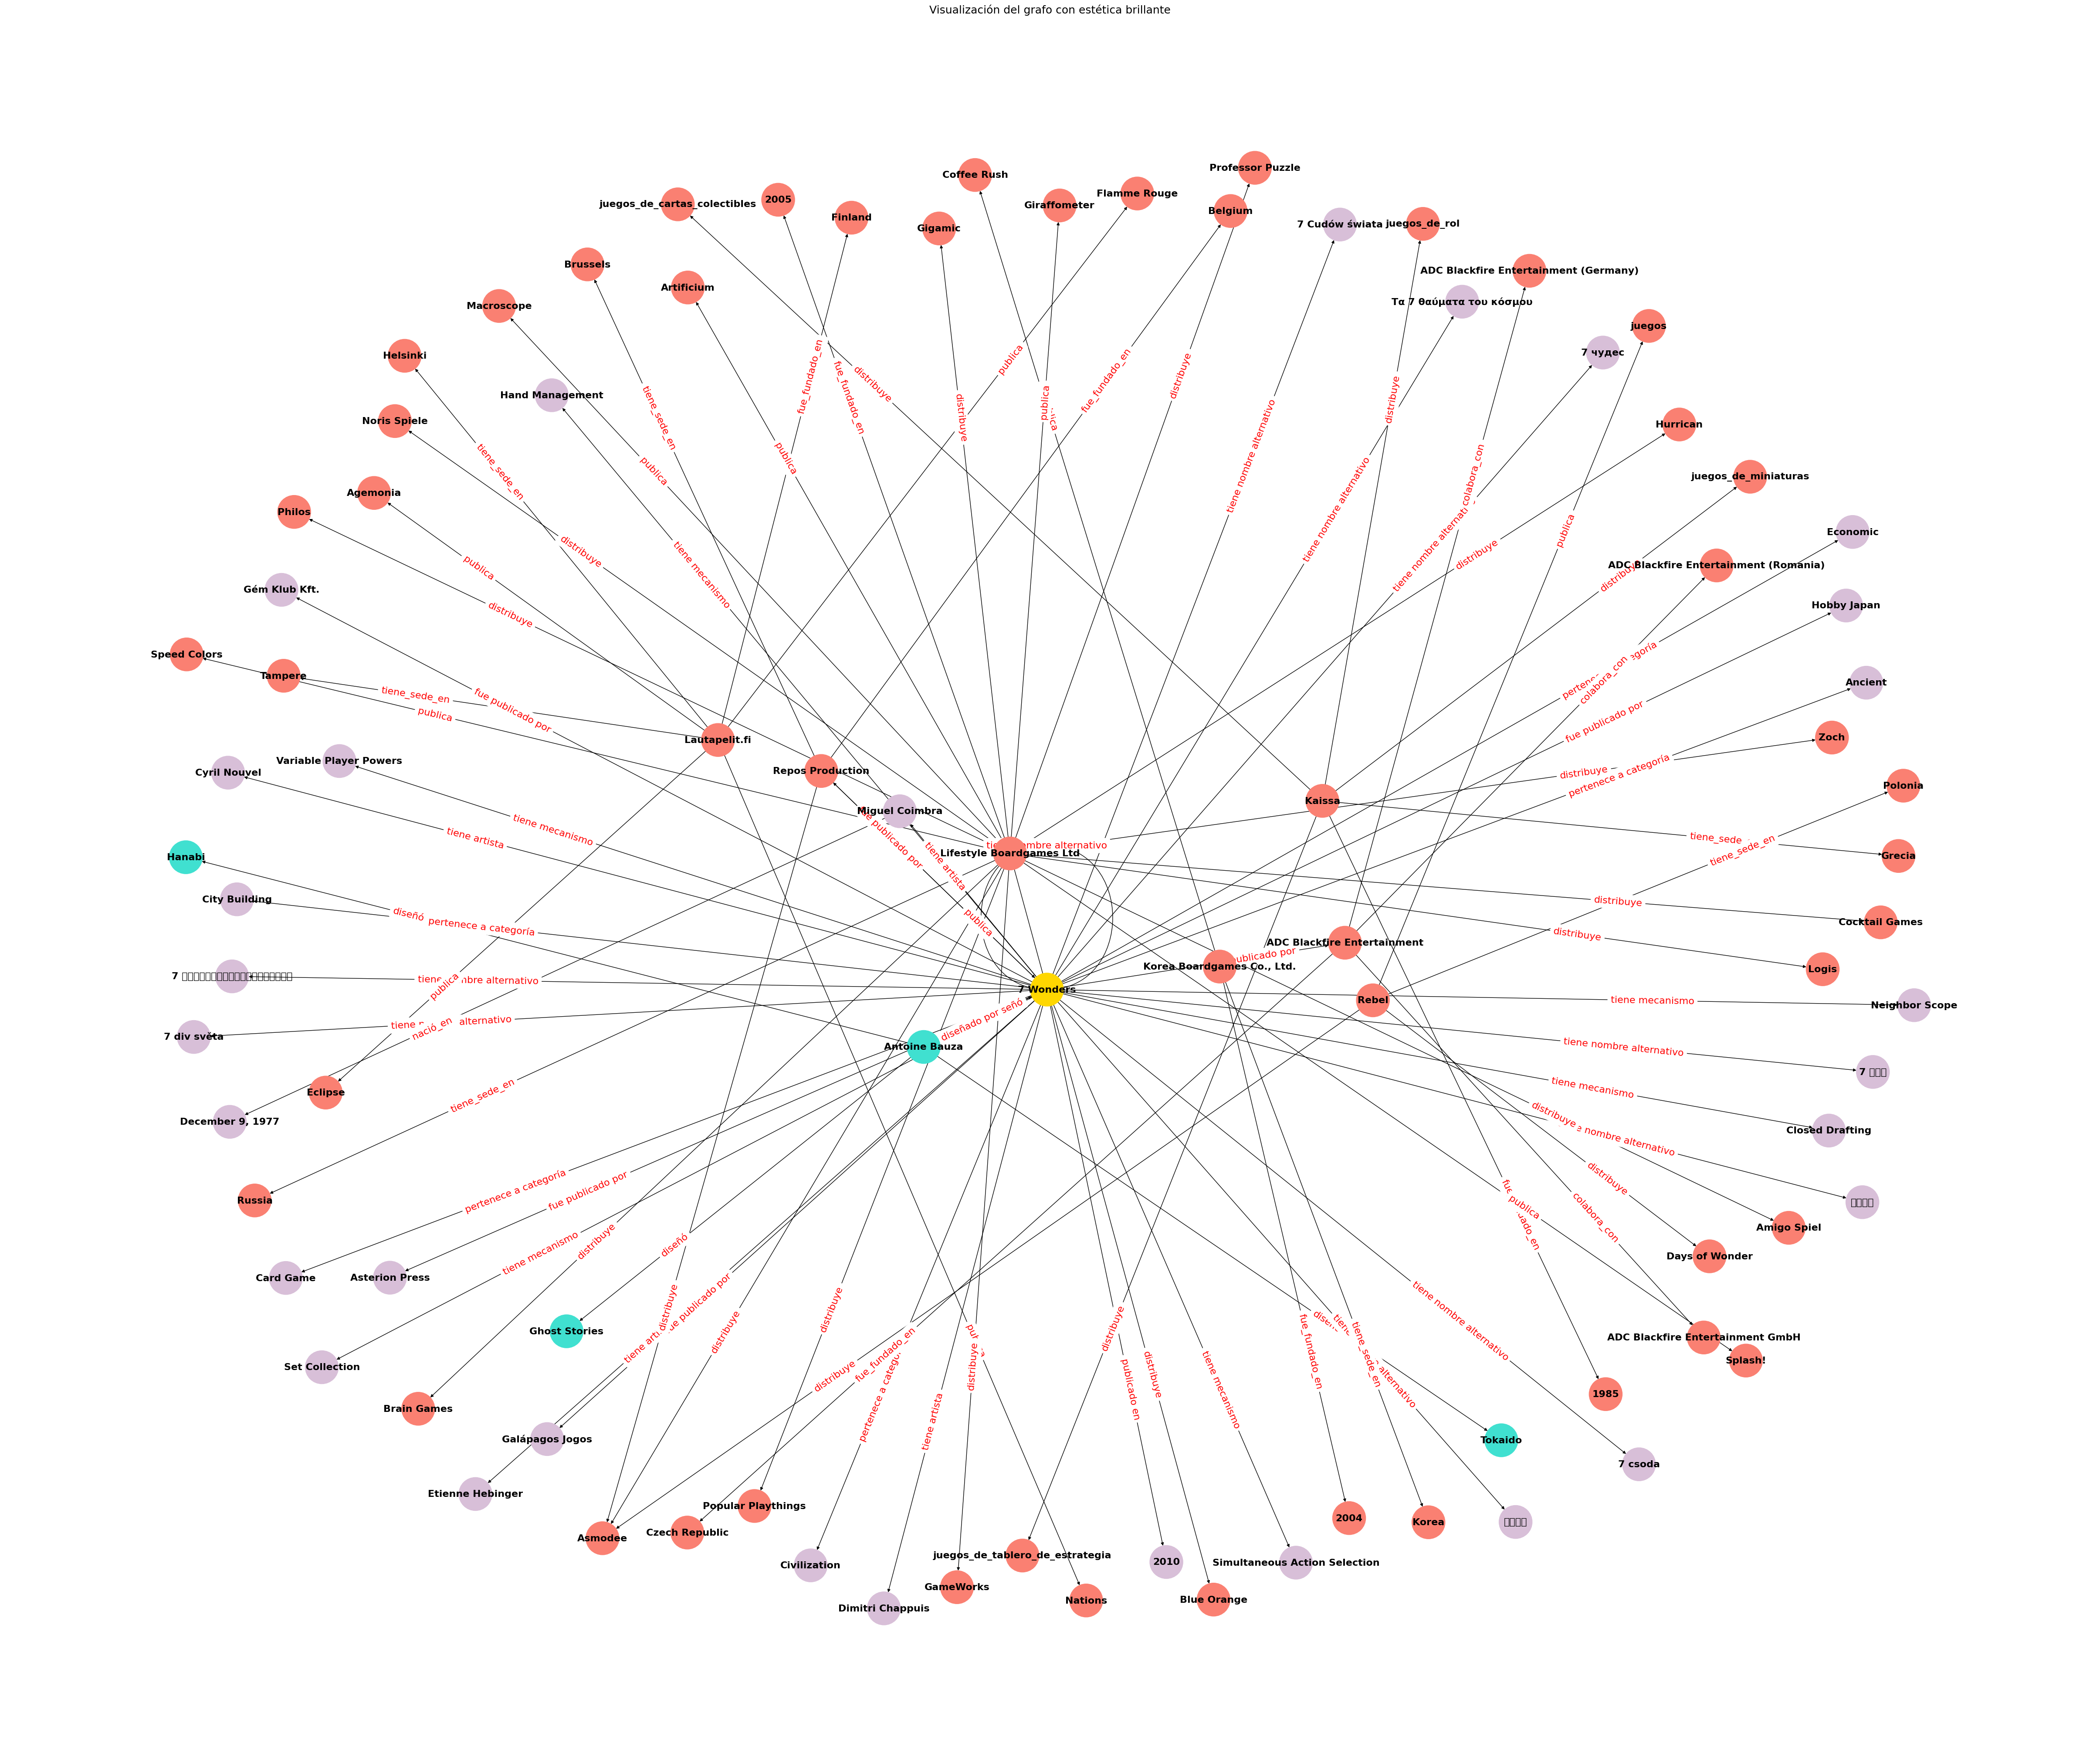

In [55]:
# Crear el grafo de networkx y el grafo RDF
G = nx.DiGraph()
g_rdf = Graph()

# Lista de datasets
datasets = [dict_designers, dict_artists, dict_publishers, dict_credits]

# Obtener el conjunto de sujetos (para identificar objetos que son sujetos en otras tripletas)
sujetos = obtener_sujetos(datasets)

# Agregar tripletas a ambos grafos
for dataset in datasets:
    agregar_tripletas_networkx(dataset, G)
    agregar_tripletas_rdf(dataset, g_rdf, sujetos)

# Visualizar el grafo de forma interactiva con plotly
visualizar_grafo(G)

In [56]:
# Serializar y mostrar el grafo RDF en formato XML
rdf_serializado = g_rdf.serialize(format="xml")

# Guardar el RDF en un archivo
with open("graph_db.rdf", "w") as file:
    file.write(rdf_serializado)

# Cargar el archivo RDF
rdf_file = "/content/graph_db.rdf"  # Reemplaza con la ruta a tu archivo
g = Graph()

# Parsear el archivo para construir el grafo
g.parse(rdf_file, format="xml")  # Cambia el formato si no es RDF/XML

print(rdf_serializado)

<?xml version="1.0" encoding="utf-8"?>
<rdf:RDF
   xmlns:ns1="http://wiki_7wonders.org/"
   xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#"
>
  <rdf:Description rdf:about="http://wiki_7wonders.org/7_Wonders">
    <ns1:fue_diseñado_por rdf:resource="http://wiki_7wonders.org/Antoine_Bauza"/>
    <ns1:tiene_artista>Dimitri Chappuis</ns1:tiene_artista>
    <ns1:tiene_artista rdf:resource="http://wiki_7wonders.org/Miguel_Coimbra"/>
    <ns1:tiene_artista>Etienne Hebinger</ns1:tiene_artista>
    <ns1:tiene_artista>Cyril Nouvel</ns1:tiene_artista>
    <ns1:fue_publicado_por rdf:resource="http://wiki_7wonders.org/Repos_Production"/>
    <ns1:fue_publicado_por rdf:resource="http://wiki_7wonders.org/ADC_Blackfire_Entertainment"/>
    <ns1:fue_publicado_por>Asterion Press</ns1:fue_publicado_por>
    <ns1:fue_publicado_por>Galápagos Jogos</ns1:fue_publicado_por>
    <ns1:fue_publicado_por>Gém Klub Kft.</ns1:fue_publicado_por>
    <ns1:fue_publicado_por>Hobby Japan</ns1:fue_publicado_por>
 

In [57]:
# Ejemplo de consulta SPARQL para recuperar todas las tripletas
query = """
SELECT ?s ?p ?o
WHERE {
  ?s ?p ?o .
}
"""

print("Resultado de la consulta SPARQL:")
for row in g_rdf.query(query):
    print(row)

Resultado de la consulta SPARQL:
(rdflib.term.URIRef('http://wiki_7wonders.org/7_Wonders'), rdflib.term.URIRef('http://wiki_7wonders.org/tiene_mecanismo'), rdflib.term.Literal('Simultaneous Action Selection'))
(rdflib.term.URIRef('http://wiki_7wonders.org/7_Wonders'), rdflib.term.URIRef('http://wiki_7wonders.org/fue_publicado_por'), rdflib.term.Literal('Galápagos Jogos'))
(rdflib.term.URIRef('http://wiki_7wonders.org/7_Wonders'), rdflib.term.URIRef('http://wiki_7wonders.org/tiene_mecanismo'), rdflib.term.Literal('Closed Drafting'))
(rdflib.term.URIRef('http://wiki_7wonders.org/Rebel'), rdflib.term.URIRef('http://wiki_7wonders.org/publica'), rdflib.term.Literal('juegos'))
(rdflib.term.URIRef('http://wiki_7wonders.org/Lautapelit.fi'), rdflib.term.URIRef('http://wiki_7wonders.org/tiene_sede_en'), rdflib.term.Literal('Tampere'))
(rdflib.term.URIRef('http://wiki_7wonders.org/7_Wonders'), rdflib.term.URIRef('http://wiki_7wonders.org/fue_publicado_por'), rdflib.term.URIRef('http://wiki_7wonde

## Queries Dinámicas




In [105]:
def extraer_entidades_y_relaciones(dataset):
    """
    Extrae entidades y relaciones de un conjunto de datos.
    """
    entidades = set()
    relaciones = []

    for sublista in dataset:
        for entrada in sublista:
            for tripleta in entrada.get('Tripletas', []):
                sujeto, predicado, objeto = tripleta
                sujeto = formatear_URI(sujeto)
                objeto = formatear_URI(objeto)
                predicado = formatear_URI(predicado)
                entidades.add(sujeto)
                entidades.add(objeto)
                relacion = (sujeto, predicado, objeto)
                relaciones.append(relacion)
    return entidades, relaciones


dataset = [dict_designers, dict_artists, dict_publishers, dict_credits]
entidades, relaciones = extraer_entidades_y_relaciones(datasets)

print(entidades)
print(relaciones)

{rdflib.term.URIRef('http://wiki_7wonders.org/Popular_Playthings'), rdflib.term.URIRef('http://wiki_7wonders.org/Neighbor_Scope'), rdflib.term.URIRef('http://wiki_7wonders.org/Ancient'), rdflib.term.URIRef('http://wiki_7wonders.org/Antoine_Bauza'), rdflib.term.URIRef('http://wiki_7wonders.org/Professor_Puzzle'), rdflib.term.URIRef('http://wiki_7wonders.org/Czech_Republic'), rdflib.term.URIRef('http://wiki_7wonders.org/juegos_de_cartas_colectibles'), rdflib.term.URIRef('http://wiki_7wonders.org/2004'), rdflib.term.URIRef('http://wiki_7wonders.org/Lifestyle_Boardgames_Ltd'), rdflib.term.URIRef('http://wiki_7wonders.org/Etienne_Hebinger'), rdflib.term.URIRef('http://wiki_7wonders.org/Hobby_Japan'), rdflib.term.URIRef('http://wiki_7wonders.org/7_Cudów_świata'), rdflib.term.URIRef('http://wiki_7wonders.org/Speed_Colors'), rdflib.term.URIRef('http://wiki_7wonders.org/Kaissa'), rdflib.term.URIRef('http://wiki_7wonders.org/Days_of_Wonder'), rdflib.term.URIRef('http://wiki_7wonders.org/Eclipse'

In [59]:
def get_query(input_text: str) -> str:
    chat_prompt = [{
        "role": "system",
        "content": f"""
Eres un modelo que genera una única consulta SPARQL para una base de datos RDF del juego "7 Wonders". La base tiene la siguiente estructura:
Entidades: {entidades}
Relaciones: {relaciones}
Diferencia entre diseñadores y creadores.
DEBES generar la consulta siguiendo exactamente este patrón:
    SELECT (STR(IF(isLiteral(?value), ?value, STRAFTER(STR(?value), "http://wiki_7_wonders.org/"))) AS ?name) WHERE {{ <URI_DEL_JUEGO> <PREDICADO> ?value }}
Reemplaza <URI_DEL_JUEGO> y <PREDICADO> según la pregunta.
Ejemplos:
- Para "¿Cuándo se creó el juego?" la consulta debe ser:
    SELECT (STR(IF(isLiteral(?value), ?value, STRAFTER(STR(?value), "http://wiki_7_wonders.org/"))) AS ?name) WHERE {{ <http://wiki_7_wonders.org/7_Wonders> <http://wiki_7_wonders.org/publicado_en> ?value }}
- Para "Quién es el diseñador de 7 Wonders?" la consulta debe ser:
    SELECT (STR(IF(isLiteral(?value), ?value, STRAFTER(STR(?value), "http://wiki_7_wonders.org/"))) AS ?name) WHERE {{ <http://wiki_7_wonders.org/7_Wonders> <http://wiki_7_wonders.org/fue_diseñado_por> ?value }}
Importante:
- Responde únicamente con la consulta SPARQL en texto plano, sin ningún delimitadoR, guiones, ni formato adicional.
- Asegúrate de que todos los paréntesis y llaves estén correctamente cerrados.
        """
    }, {
        "role": "user",
        "content": input_text
    }]

    completion = client_HF.chat.completions.create(
        model="Qwen/Qwen2.5-72B-Instruct",
        messages=chat_prompt,
        max_tokens=500,
        temperature=0.1
    )

    return completion.choices[0].message['content']


In [60]:
# Obtener la consulta SPARQL generada
sparql_query = get_query("Menciona los publicadores de 7 Wonders")

# Imprimir la consulta generada
print("Consulta SPARQL generada:")
print(sparql_query)

results = g.query(sparql_query)
for row in results:
    print(row.name)

Consulta SPARQL generada:
SELECT (STR(IF(isLiteral(?value), ?value, STRAFTER(STR(?value), "http://wiki_7_wonders.org/"))) AS ?name) WHERE { <http://wiki_7_wonders.org/7_Wonders> <http://wiki_7_wonders.org/fue_publicado_por> ?value }


In [61]:
# Obtener la consulta SPARQL generada
sparql_query = get_query("¿Cuándo se creó el juego?")

# Imprimir la consulta generada
print("Consulta SPARQL generada:")
print(sparql_query)

results = g.query(sparql_query)
for row in results:
    print(row.name)

Consulta SPARQL generada:
SELECT (STR(IF(isLiteral(?value), ?value, STRAFTER(STR(?value), "http://wiki_7_wonders.org/"))) AS ?name) WHERE { <http://wiki_7wonders.org/7_Wonders> <http://wiki_7wonders.org/publicado_en> ?value }
2010


In [62]:
def search_graph(natural_query: str) -> str:
    # Genera la consulta SPARQL a partir de la consulta en lenguaje natural.
    sparql_query = get_query(natural_query)

    # Ejecuta la consulta sobre el grafo RDF.
    results = g.query(sparql_query)

    # Extrae los resultados de la variable ?name y los convierte a cadena.
    answers = [str(row.name) for row in results]

    # Si se obtuvieron resultados, se unen en una cadena separada por comas;
    # de lo contrario se indica que no se encontró ningún resultado.
    if answers:
        return ", ".join(answers)
    else:
        return "No se encontraron resultados para la consulta proporcionada."

In [63]:
search_graph("¿Cuándo se creó el juego?")

'2010'

In [64]:
search_graph("¿en qué juegos participó el diseñador de 7 Wonders?")

', Hanabi, Ghost Stories, Tokaido'

In [65]:
search_graph("¿Cuáles son los nombres alternativos de 7 Wonders?")

'7 csoda, 7 Cudów świata, 7 div světa, 7 чудес, 7 ความมหัศจรรย์ของโลก, 7 대기적, Τα 7 θαύματα του κόσμου, 七大奇观, 七大奇迹, '

In [66]:
search_graph("¿Quiénes son los artistas de 7 Wonders?")

'Dimitri Chappuis, , Etienne Hebinger, Cyril Nouvel'

## Base de datos tabular

### Extraer información

In [67]:
def obtener_estadisticas_y_valores(url):
    '''
    Descripción:
    Recoge estadísticas y valores de una página web utilizando Selenium, extrayendo información relevante sobre estadísticas de juegos y jugadores a partir de elementos HTML específicos.

    -------------------------------------------------------------------------------------------------

    Parámetros:
    - url (str): La URL de la página web de la cual se extraerán las estadísticas.

    -------------------------------------------------------------------------------------------------

    Retorna:
    - list: Una lista de diccionarios, donde cada diccionario contiene una "Entidad" y su "Valor" correspondiente, representando una estadística de la página.

    -------------------------------------------------------------------------------------------------

    Procedimiento:
    1. Configura el entorno de Selenium para utilizar Chrome en modo headless (sin interfaz gráfica) y con opciones específicas para evitar problemas de entorno.
    2. Abre la URL proporcionada y espera a que los elementos relevantes en la página sean visibles.
    3. Extrae las entidades (títulos) y los valores asociados de los elementos de la página:
      - Cada entidad es un título que describe un tipo de estadística.
      - Los valores son los números o datos asociados a cada entidad.
    4. Realiza una serie de transformaciones en los nombres de las entidades para estandarizarlos a términos más comprensibles.
    5. Almacena cada par de entidad y valor en la lista `resultados`.
    6. Si ocurre algún error al intentar extraer los datos de algún elemento, lo omite y continúa con el siguiente.
    7. Cierra el navegador y devuelve la lista de resultados con las estadísticas extraídas.
    '''

    chrome_options = Options()
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    chrome_options.add_argument('--disable-gpu')

    # Configurar la ruta del driver
    service = Service('/usr/bin/chromedriver')

    driver = webdriver.Chrome(options=chrome_options)

    driver.get(url)
    # Crear una lista para almacenar los resultados
    resultados = []

    # Espera explícita para asegurarse de que la página cargue completamente
    try:
        # Espera a que los elementos <li> con la clase "outline-item" sean visibles
        WebDriverWait(driver, 10).until(
            EC.presence_of_all_elements_located((By.CSS_SELECTOR, 'li.outline-item'))
        )

        # Encuentra todos los elementos <li> con la clase "outline-item"
        items = driver.find_elements(By.CSS_SELECTOR, 'li.outline-item')

        # Itera sobre los elementos y extrae la entidad y el valor
        for item in items:
            try:
                # Encuentra la entidad (titulo) dentro del div con clase "outline-item-title"
                entidad = item.find_element(By.CSS_SELECTOR, 'div.outline-item-title').text.strip()

                if entidad == 'All time Plays':
                    entidad ='Total of players'
                elif entidad == 'This Month':
                    entidad ='Players this Month'
                elif entidad == 'Own':
                    entidad ='Players who own the game'
                elif entidad == 'Prev. Owned':
                    entidad ='Players who owned the game before but not now'
                elif entidad == 'For Trade':
                    entidad ='Players who have the game for trade'
                elif entidad == 'Want In Trade':
                    entidad ='Players who want the game in trade'
                elif entidad == 'Wishlist':
                    entidad ='Players who have the game in their wishlist'
                elif entidad == 'Has Parts':
                    entidad ='Players who have parts of the game'
                elif entidad == 'Want Parts':
                    entidad ='Players who want parts of the game'

                # Encuentra el valor (rating) dentro del div con clase "outline-item-description"
                valor = item.find_element(By.CSS_SELECTOR, 'div.outline-item-description a').text.strip()

                # Almacena el resultado en el formato 'Entidad: Valor'
                resultados.append({'Entidad': entidad, 'Valor': valor})
            except Exception as e:
                # Si ocurre un error al extraer los datos de una entidad, lo omite
                pass
    except Exception as e:
        print(f"Error al esperar elementos: {e}")

    # Cierra el navegador
    driver.quit()

    # Devuelve la lista de resultados
    return resultados

### Crear base tabular

In [68]:
# Definir la URL del juego en BoardGameGeek
url_stats = 'https://boardgamegeek.com/boardgame/68448/7-wonders/stats'

# Obtener los valores de la página web
valores = obtener_estadisticas_y_valores(url_stats)

# Convertir los valores en un DataFrame
df_valores = pd.DataFrame(valores)

# Aplicar la función embed() correctamente si está definida
# Asegúrate de que embed() esté importado y definido en tu código
if 'embed' in globals():  # Verifica si embed está definido
    df_valores['Embedding'] = df_valores.apply(
        lambda row: embed(f"{row['Entidad']}: {row['Valor']}").numpy().flatten().tolist(), axis=1
    )

# Guardar el DataFrame antes de leerlo
df_valores.to_csv('tabular_db.csv', index=False)

# Ahora sí se puede leer sin error
df_valores = pd.read_csv('tabular_db.csv')

# Eliminar columnas si existen
if 'Unnamed: 0' in df_valores.columns and 'Embedding' in df_valores.columns:
    df_valores.drop(columns=['Unnamed: 0', 'Embedding'], inplace=True)

df_valores

Entidad     Valor  \
0                                     Avg. Rating     7.674   
1                                  No. of Ratings   107,923   
2                                          Weight  2.32 / 5   
3                                        Comments    16,744   
4                                            Fans     7,309   
5                                    Overall Rank       103   
6                                   Strategy Rank       114   
7                                     Family Rank        18   
8                                  All Time Plays   622,304   
9                              Players this Month     1,967   
10                       Players who own the game   147,773   
11  Players who owned the game before but not now    12,077   
12            Players who have the game for trade     1,910   
13             Players who want the game in trade       984   
14    Players who have the game in their wishlist    14,301   
15             Players who have parts of the game        46   
16             Players who want parts of the game        48   

                                            Embedding  
0   [0.08176780492067337, 0.04086339473724365, 0.0...  
1   [0.06983771175146103, 0.0406700074672699, -0.0...  
2   [0.07377806305885315, -0.03099851682782173, 0....  
3   [0.04083557054400444, 0.05355497822165489, -0....  
4   [0.048907313495874405, -0.0018585778307169676,...  
5   [0.08439179509878159, 0.0011270452523604035, 0...  
6   [0.09388801455497742, 0.02118225209414959, -0....  
7   [0.07927840203046799, -0.04649476334452629, -0...  
8   [-0.02371472492814064, -0.00817945133894682, 0...  
9   [0.004980423953384161, -0.013586429879069328, ...  
10  [-0.05122365429997444, 0.05856835097074509, 0....  
11  [-0.053749844431877136, 0.01478572841733694, 0...  
12  [-0.05665670707821846, -0.014034543186426163, ...  
13  [-0.05529123544692993, 0.00735127879306674, 0....  
14  [-0.04929947480559349, 0.04115702584385872, 0....  
15  [-0.0370328426361084, 0.053439173847436905, 0....  
16  [-0.028690459206700325, 0.06697879731655121, -...

## Queries Dinámicas

In [113]:
# Cargar la base de datos tabular previamente guardada
df_valores = pd.read_csv('tabular_db.csv')

# Limpieza de columnas innecesarias
if 'Unnamed: 0' in df_valores.columns:
    df_valores.drop(columns=['Unnamed: 0'], inplace=True)
if 'Embedding' in df_valores.columns:
    df_valores.drop(columns=['Embedding'], inplace=True)

def preprocesar_prompt(prompt):
    """
    Transforma la consulta en español a la entidad en inglés utilizada en la base de datos,
    utilizando un LLM para evitar reglas fijas y palabras hardcoded.

    Parámetros:
      - prompt (str): Consulta en lenguaje natural en español.

    Retorna:
      - str: Entidad en inglés mapeada.
    """
    # Obtener la lista de entidades disponibles de la base de datos
    list_entities = df_valores['Entidad'].tolist()
    # Preparar un prompt para el LLM que le indique las entidades disponibles y solicite
    # determinar a cuál se refiere la consulta.
    prompt_llm = (
        f"De las siguientes entidades: {', '.join(list_entities)}. "
        f"Dada la consulta en español: '{prompt}', indica cuál es la entidad en inglés a la que se refiere. "
        "Responde únicamente con la entidad exacta."
    )

    # Preparar el chat prompt para el LLM
    chat_prompt = [
        {"role": "system", "content": "Eres un asistente que mapea consultas en español a entidades de una base de datos."},
        {"role": "user", "content": prompt_llm}
    ]

    # Invocar al LLM con la sintaxis correcta
    completion = client_HF.chat.completions.create(
        model="Qwen/Qwen2.5-72B-Instruct",
        messages=chat_prompt,
        max_tokens=500,
        temperature=0.1
    )

    # Extraer la respuesta y eliminar espacios en blanco
    entity = completion.choices[0].message['content'].strip()
    return entity

def search_tabular(prompt, df):
    """
    Realiza una consulta dinámica a la base de datos a partir de un prompt en lenguaje natural (en español).

    Parámetros:
      - prompt (str): Consulta en lenguaje natural.
      - df (DataFrame): Base de datos tabular con las columnas 'Entidad' y 'Valor'.

    Retorna:
      - str: Respuesta en lenguaje natural con los datos relevantes o un mensaje de no hallazgo.
    """
    # Preprocesar el prompt para obtener la entidad correspondiente de forma dinámica
    prompt_preproc = preprocesar_prompt(prompt)
    # Lista de entidades disponibles en la base de datos
    entidades = df['Entidad'].tolist()
    # Buscar la mejor coincidencia entre el prompt preprocesado y las entidades disponibles
    matches = difflib.get_close_matches(prompt_preproc, entidades, n=1, cutoff=0.3)

    if matches:
        entidad_match = matches[0]
        resultado = df[df['Entidad'] == entidad_match]
        if resultado.empty:
            return f"No se encontraron datos para la entidad '{entidad_match}'."
        else:
            valor = resultado.iloc[0]['Valor']
            return f"La entidad '{entidad_match}' tiene el valor: {valor}."
    else:
        return "No se encontró ninguna entidad que coincida con la consulta."


In [114]:
prompt1 = "¿Cuál es la calificación promedio?"
respuesta1 = search_tabular(prompt1, df_valores)
print(respuesta1)

La entidad 'Avg. Rating' tiene el valor: 7.674.


In [115]:
prompt2 = "¿Cuántas calificaciones se han registrado?"
respuesta2 = search_tabular(prompt2, df_valores)
print(respuesta2)

La entidad 'No. of Ratings' tiene el valor: 107,923.


In [116]:
prompt5 = "¿Cuántos jugadores desean partes del juego?"
respuesta5 = search_tabular(prompt5, df_valores)
print(respuesta5)

La entidad 'Players who want parts of the game' tiene el valor: 48.


## Clasificador

In [73]:
api_key = 'api-key'

client = InferenceClient(model="Qwen/Qwen2.5-72B-Instruct", token=api_key)

model_name = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = SentenceTransformer(model_name) # Modelo optimizado para embedding

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### Basado en un modelo entrenado con ejemplos y embeddings

In [74]:
data = [
    # --------------------------------------------------------------------------------
    # LABEL 0
    # --------------------------------------------------------------------------------
    {"query": "extract the section 'contenido' from the manual.", "label": 0},
    {"query": "retrieve the text from the 'en resumen' section of the pdf.", "label": 0},
    {"query": "get the details from the 'elementos del juego' section.", "label": 0},
    {"query": "obtain the instructions from the 'preparación' section.", "label": 0},
    {"query": "fetch the summary from the 'resumen de la partida' section.", "label": 0},
    {"query": "retrieve the translation of the cards from the 'traducción de las cartas' section.", "label": 0},
    {"query": "extract the content from the 'fin de la partida' section.", "label": 0},
    {"query": "get the description provided in the 'descripción' section.", "label": 0},
    {"query": "obtain the leader details from the 'descripción de los líderes' section.", "label": 0},
    {"query": "retrieve the guild information from the 'descripción de los gremios' section.", "label": 0},
    {"query": "fetch the wonders details from the 'descripción de las maravillas' section.", "label": 0},
    {"query": "get the rules for 2 players from the 'reglas para 2 jugadores' section.", "label": 0},
    {"query": "extract the rules for 8 players from the 'reglas para 8 jugadores' section.", "label": 0},
    {"query": "obtain the team play guidelines from the 'reglas para el juego por equipos' section.", "label": 0},
    {"query": "retrieve the frequently asked questions from the 'preguntas frecuentes' section.", "label": 0},
    {"query": "fetch the credits information from the 'créditos' section.", "label": 0},
    {"query": "get the symbols description from the 'descripción de los símbolos' section.", "label": 0},
    {"query": "retrieve additional setup information from the manual's content.", "label": 0},
    {"query": "extract the overview of game mechanics from the pdf content.", "label": 0},
    {"query": "obtain the instructions for card drafting as outlined in the manual.", "label": 0},
    {"query": "what is the overview of the game as described in the video review content?", "label": 0},
    {"query": "explain the game feel as mentioned in the video review.", "label": 0},
    {"query": "what decision-making aspects are highlighted in the video review description?", "label": 0},
    {"query": "describe the simultaneous play mechanism explained in the video review.", "label": 0},
    {"query": "how are victory points distributed according to the video review?", "label": 0},
    {"query": "explain the role of resource management as detailed in the video review.", "label": 0},
    {"query": "what strategic choices are outlined in the video review content?", "label": 0},
    {"query": "how does the review describe the card drafting process?", "label": 0},
    {"query": "what insights are offered about military conflicts in the video review?", "label": 0},
    {"query": "describe the balance of luck and skill in the game as per the video review.", "label": 0},
    {"query": "what does the video review say about the game setup time?", "label": 0},
    {"query": "summarize the review's opinion on the depth and playtime of the game.", "label": 0},
    {"query": "what does the review mention about the game's components included in the box?", "label": 0},
    {"query": "list the game components detailed in the review's 'contenido' section.", "label": 0},
    {"query": "what are the dimensions and weight of the game box as described in the review?", "label": 0},
    {"query": "explain the basic game mechanics outlined in the review.", "label": 0},
    {"query": "what key points are discussed in the 'conceptos básicos' section of the review?", "label": 0},
    {"query": "describe the seven types of construction cards mentioned in the review.", "label": 0},
    {"query": "what does the review explain about resource generation and trading?", "label": 0},
    {"query": "explain the conflict resolution process as described in the review.", "label": 0},
    {"query": "what information is provided about coin usage in the game according to the review?", "label": 0},
    {"query": "summarize the setup process for the game as detailed in the review.", "label": 0},
    {"query": "what variations for a two-player game are mentioned in the review?", "label": 0},
    {"query": "how does the review describe the progression through the three ages of the game?", "label": 0},
    {"query": "what strategic elements are highlighted in the review's opinion section?", "label": 0},
    {"query": "explain the importance of neighboring players in the game as per the review.", "label": 0},
    {"query": "what criticisms does the review offer regarding the game's replayability?", "label": 0},
    {"query": "describe the review's view on the cost and overall value of the game.", "label": 0},
    {"query": "what does the review suggest about the game's appeal to experienced players?", "label": 0},
    {"query": "summarize the final thoughts on the overall game experience as stated in the review.", "label": 0},
    {"query": "extract any designer notes mentioned in the pdf content.", "label": 0},
    {"query": "retrieve instructions about resource production from the manual.", "label": 0},
    {"query": "get the tips for first-time players from the pdf's early sections.", "label": 0},
    {"query": "obtain details regarding scoring examples from the pdf content.", "label": 0},
    {"query": "fetch the explanation about building stages from the manual.", "label": 0},
    {"query": "retrieve the artwork descriptions provided in the pdf sections.", "label": 0},
    {"query": "extract the clarifications on trading rules found in the manual.", "label": 0},
    {"query": "get the explanation of iconography from the pdf content.", "label": 0},
    {"query": "obtain all notes on expansions mentioned in the manual's text.", "label": 0},
    {"query": "retrieve final remarks about gameplay pacing in the pdf.", "label": 0},
    {"query": "extract the setup variations for different player counts from the pdf.", "label": 0},
    {"query": "get clarifications on the use of coins as per the manual sections.", "label": 0},
    {"query": "obtain extended examples of playthrough from the pdf content.", "label": 0},
    {"query": "fetch the section addressing advanced strategies in the manual.", "label": 0},
    {"query": "retrieve notes on player interaction from the pdf's final pages.", "label": 0},
    {"query": "extract the introduction portion describing the game's theme.", "label": 0},
    {"query": "get the guidelines for tiebreakers mentioned in the pdf content.", "label": 0},
    {"query": "obtain the manual's recommended player aids and references.", "label": 0},
    {"query": "fetch clarifications regarding simultaneous actions in the pdf.", "label": 0},
    {"query": "retrieve any disclaimers or official clarifications from the manual.", "label": 0},
    {"query": "extract the advanced rule variants listed in the pdf.", "label": 0},
    {"query": "get the complete game glossary found in the manual sections.", "label": 0},
    {"query": "obtain details on card color coding from the pdf content.", "label": 0},
    {"query": "retrieve specific examples of wonder abilities from the manual.", "label": 0},
    {"query": "extract rules about discarding cards from the pdf resource.", "label": 0},
    {"query": "get additional notes about science icons from the manual.", "label": 0},
    {"query": "obtain best practices for teaching the game from the pdf text.", "label": 0},
    {"query": "fetch the official round structure details from the manual.", "label": 0},
    {"query": "retrieve guidelines on combining expansions with the base game.", "label": 0},
    {"query": "extract the authors' acknowledgments from the pdf content.", "label": 0},
    {"query": "get the statement on recommended age range from the manual.", "label": 0},
    {"query": "obtain info on setting up the game with expansions from the pdf.", "label": 0},
    {"query": "fetch the official clarifications about leader cards from the manual.", "label": 0},
    {"query": "retrieve an explanation of the different symbol types from the pdf.", "label": 0},
    {"query": "extract the section about end-of-age processes in the manual.", "label": 0},
    {"query": "get the designer's rationale behind card drafting from the pdf.", "label": 0},
    {"query": "obtain notes on how to handle incomplete sets of resources in the manual.", "label": 0},
    {"query": "fetch the variant rules for experienced players from the pdf content.", "label": 0},
    {"query": "retrieve any official errata mentioned in the manual's final pages.", "label": 0},
    {"query": "extract clarifications about borrowing resources from the pdf text.", "label": 0},
    {"query": "get the full description of conflict resolution from the manual sections.", "label": 0},
    {"query": "obtain the references to expansions in the pdf's table of contents.", "label": 0},
    {"query": "fetch the manual's instructions for combining base game and expansions seamlessly.", "label": 0},
    {"query": "retrieve additional clarifications on building chain icons from the pdf.", "label": 0},
    {"query": "extract recommended house rules from the official pdf content.", "label": 0},
    {"query": "get the explanation of each guild card function from the manual.", "label": 0},
    {"query": "obtain the overview of historical references mentioned in the pdf.", "label": 0},
    {"query": "fetch the recommended board layout suggestions from the manual text.", "label": 0},
    {"query": "retrieve step-by-step examples of a single turn from the pdf content.", "label": 0},
    {"query": "extract any official game expansions listed by name in the manual.", "label": 0},
    {"query": "get tips for managing currency throughout the game from the pdf text.", "label": 0},

    # --------------------------------------------------------------------------------
    # LABEL 1
    # --------------------------------------------------------------------------------
    {"query": "who designed 7 wonders?", "label": 1},
    {"query": "what is the name of the game in the graph database?", "label": 1},
    {"query": "who is the publisher of 7 wonders?", "label": 1},
    {"query": "which year was 7 wonders released?", "label": 1},
    {"query": "who are the artists involved in 7 wonders?", "label": 1},
    {"query": "what alternative names does 7 wonders have?", "label": 1},
    {"query": "who are the designers of 7 wonders?", "label": 1},
    {"query": "which game is related to 7 wonders in the graph?", "label": 1},
    {"query": "what is the category of 7 wonders in the graph database?", "label": 1},
    {"query": "who is credited as the designer in the graph?", "label": 1},
    {"query": "what games were designed by the lead designer of 7 wonders?", "label": 1},
    {"query": "who is the primary artist according to the graph data?", "label": 1},
    {"query": "which publisher is associated with 7 wonders?", "label": 1},
    {"query": "what is the relationship between 7 wonders and its award nodes?", "label": 1},
    {"query": "who is listed as the publisher in the graph?", "label": 1},
    {"query": "which nodes represent alternative names for 7 wonders?", "label": 1},
    {"query": "what is the connection between 7 wonders and its designers?", "label": 1},
    {"query": "who are the collaborators in the design of 7 wonders?", "label": 1},
    {"query": "which artist worked on 7 wonders according to the graph?", "label": 1},
    {"query": "what is the release year of 7 wonders in the graph?", "label": 1},
    {"query": "who are the award recipients linked to 7 wonders?", "label": 1},
    {"query": "what is the relationship 'designed by' in the graph for 7 wonders?", "label": 1},
    {"query": "which game is shown as inspired by 7 wonders in the graph?", "label": 1},
    {"query": "who is the secondary designer of 7 wonders?", "label": 1},
    {"query": "what is the graph node for the game's category?", "label": 1},
    {"query": "who is the artist associated with the main game node?", "label": 1},
    {"query": "which designer has other games connected in the graph?", "label": 1},
    {"query": "what publisher node is linked to 7 wonders?", "label": 1},
    {"query": "who is the main designer listed in the graph data?", "label": 1},
    {"query": "what alternative name node is connected to 7 wonders?", "label": 1},
    {"query": "which relationship in the graph indicates game awards?", "label": 1},
    {"query": "who designed the additional games in the graph related to 7 wonders?", "label": 1},
    {"query": "what does the 'art by' edge represent in the graph for 7 wonders?", "label": 1},
    {"query": "who is shown as the game publisher in the graph database?", "label": 1},
    {"query": "what is the connection between 7 wonders and its release year?", "label": 1},
    {"query": "which nodes represent designers in the graph of 7 wonders?", "label": 1},
    {"query": "who are the collaborators noted in the 7 wonders graph?", "label": 1},
    {"query": "what is the graph relationship for 'inspired by' in 7 wonders?", "label": 1},
    {"query": "which game is connected as an alternative name in the graph?", "label": 1},
    {"query": "who is responsible for the visual design in the 7 wonders graph?", "label": 1},
    {"query": "which node links 7 wonders with its associated awards?", "label": 1},
    {"query": "what graph edge represents the 'published by' relationship for 7 wonders?", "label": 1},
    {"query": "who are the supporting designers connected in the graph?", "label": 1},
    {"query": "which relationship in the graph shows the connection to the release year?", "label": 1},
    {"query": "what node identifies the game category for 7 wonders?", "label": 1},
    {"query": "which expansions are linked to 7 wonders in the graph?", "label": 1},
    {"query": "how is the language of the game represented in the graph nodes?", "label": 1},
    {"query": "who is marked as a co-designer in the data for 7 wonders?", "label": 1},
    {"query": "what edges show expansions related to 7 wonders in the graph?", "label": 1},
    {"query": "which publisher node is connected to expansions of 7 wonders?", "label": 1},
    {"query": "does the graph show any inspiration edges linking 7 wonders to other titles?", "label": 1},
    {"query": "who are the artists credited for expansions in the graph?", "label": 1},
    {"query": "which design teams are associated with 7 wonders in the database?", "label": 1},
    {"query": "what additional publisher data is recorded for 7 wonders in the graph?", "label": 1},
    {"query": "how are the award nodes structured for 7 wonders in the graph?", "label": 1},
    {"query": "which node in the graph indicates expansions directly based on 7 wonders?", "label": 1},
    {"query": "who is credited with rulebook editing in the graph data, if any?", "label": 1},
    {"query": "which relationship connects the year of revision to 7 wonders in the graph?", "label": 1},
    {"query": "does the graph have a node for the city expansions of 7 wonders?", "label": 1},
    {"query": "who is the primary distribution partner in the 7 wonders graph?", "label": 1},
    {"query": "is there a node representing translations for 7 wonders in the graph?", "label": 1},
    {"query": "how many award edges are associated with 7 wonders in the graph database?", "label": 1},
    {"query": "which designer node references the expansions in the graph for 7 wonders?", "label": 1},
    {"query": "is there a 'based on' relationship in the graph for expansions of 7 wonders?", "label": 1},
    {"query": "which node indicates the local distributor for 7 wonders, if any?", "label": 1},
    {"query": "are there multiple publisher relationships in the 7 wonders graph data?", "label": 1},
    {"query": "how is the original title for 7 wonders represented in the graph?", "label": 1},
    {"query": "which award node includes the kennerspiel des jahres for 7 wonders?", "label": 1},
    {"query": "what node references the official expansions within the 7 wonders network?", "label": 1},
    {"query": "is there any mention of the artist's style in the graph for 7 wonders?", "label": 1},
    {"query": "which nodes are labeled as official expansions in the 7 wonders graph?", "label": 1},
    {"query": "how does the graph record any variant names for 7 wonders expansions?", "label": 1},
    {"query": "what is the node linking 7 wonders to specialized awards or honors?", "label": 1},
    {"query": "which node details expansions like 'leaders' or 'cities' for 7 wonders?", "label": 1},
    {"query": "how is an expansion release date shown in the 7 wonders graph?", "label": 1},
    {"query": "does the graph specify any co-publisher relationships for 7 wonders?", "label": 1},
    {"query": "what label does the database use for expansions of 7 wonders?", "label": 1},
    {"query": "which entry in the graph references spin-off games of 7 wonders?", "label": 1},
    {"query": "who updated the design for expansions, according to the graph?", "label": 1},
    {"query": "which relationships indicate the expansions' designers for 7 wonders?", "label": 1},
    {"query": "is there a relationship that notes reimplementation of 7 wonders in the graph?", "label": 1},
    {"query": "how are the wonder boards themselves represented, if at all, in the graph?", "label": 1},
    {"query": "which node ties 7 wonders to collaborative design efforts?", "label": 1},
    {"query": "how many official expansions does the graph show for 7 wonders?", "label": 1},
    {"query": "which node describes the reprint of 7 wonders in the graph data?", "label": 1},
    {"query": "do we have an edge indicating game families related to 7 wonders?", "label": 1},
    {"query": "which node references the expansions' new wonder boards in the graph?", "label": 1},
    {"query": "who is credited with artistic direction for expansions in the 7 wonders graph?", "label": 1},
    {"query": "does the graph differentiate expansions and promos for 7 wonders?", "label": 1},
    {"query": "what is the 'license holder' node for 7 wonders if present?", "label": 1},
    {"query": "which graph edge shows expansions forming a series with the base game?", "label": 1},
    {"query": "how is the base game node connected to expansions like 'babel'?", "label": 1},
    {"query": "is there a node referencing multiple award nominations for 7 wonders?", "label": 1},
    {"query": "which design team node is indicated for 7 wonders expansions?", "label": 1},
    {"query": "are there separate nodes for expansions that add new cards to 7 wonders?", "label": 1},
    {"query": "how do we see the 'inspired expansions' relationship for 7 wonders in the graph?", "label": 1},
    {"query": "who is documented as a creative consultant in the 7 wonders graph?", "label": 1},

    # --------------------------------------------------------------------------------
    # LABEL 2
    # --------------------------------------------------------------------------------
    {"query": "what is the average rating of 7 wonders?", "label": 2},
    {"query": "how many ratings has 7 wonders received?", "label": 2},
    {"query": "what is the total number of plays recorded for 7 wonders?", "label": 2},
    {"query": "how many players currently own 7 wonders?", "label": 2},
    {"query": "what is the weight of 7 wonders as per statistics?", "label": 2},
    {"query": "what is the overall rank of 7 wonders?", "label": 2},
    {"query": "how many monthly players does 7 wonders have?", "label": 2},
    {"query": "what is the average playtime of 7 wonders?", "label": 2},
    {"query": "how many fans does 7 wonders have in total?", "label": 2},
    {"query": "what is the number of ratings for 7 wonders?", "label": 2},
    {"query": "how many players have played 7 wonders all time?", "label": 2},
    {"query": "what is the average score given to 7 wonders?", "label": 2},
    {"query": "how many players own 7 wonders according to statistics?", "label": 2},
    {"query": "what is the global ranking of 7 wonders?", "label": 2},
    {"query": "how many comments are registered for 7 wonders?", "label": 2},
    {"query": "what is the average number of plays per month for 7 wonders?", "label": 2},
    {"query": "how difficult is it to learn 7 wonders based on ratings?", "label": 2},
    {"query": "what is the players' rating for 7 wonders?", "label": 2},
    {"query": "how many players had previously owned 7 wonders?", "label": 2},
    {"query": "what is the number of players who have the game for trade?", "label": 2},
    {"query": "how many players want to trade 7 wonders?", "label": 2},
    {"query": "what is the statistic for players on the wishlist of 7 wonders?", "label": 2},
    {"query": "how many players have parts of 7 wonders?", "label": 2},
    {"query": "what is the statistic for players who want parts of 7 wonders?", "label": 2},
    {"query": "how many fans are recorded in the 7 wonders statistics?", "label": 2},
    {"query": "what is the overall rating score of 7 wonders?", "label": 2},
    {"query": "how many ratings are listed in the 7 wonders tabular data?", "label": 2},
    {"query": "what is the average play rating of 7 wonders?", "label": 2},
    {"query": "how many players have been recorded playing 7 wonders?", "label": 2},
    {"query": "what is the detailed rating statistic of 7 wonders?", "label": 2},
    {"query": "how many players are active monthly for 7 wonders?", "label": 2},
    {"query": "what is the overall number of plays for 7 wonders?", "label": 2},
    {"query": "how many players are noted as owning 7 wonders?", "label": 2},
    {"query": "what is the rating average for 7 wonders in the statistics?", "label": 2},
    {"query": "how many players are reported in the 7 wonders dataset?", "label": 2},
    {"query": "what is the average review score for 7 wonders?", "label": 2},
    {"query": "how many times has 7 wonders been played?", "label": 2},
    {"query": "what is the number of players who rated 7 wonders?", "label": 2},
    {"query": "how many comments or reviews does 7 wonders have?", "label": 2},
    {"query": "what is the detailed statistic of 7 wonders in the tabular database?", "label": 2},
    {"query": "how many overall plays are recorded for 7 wonders?", "label": 2},
    {"query": "what is the number of players currently active for 7 wonders?", "label": 2},
    {"query": "how many ratings and reviews does 7 wonders have combined?", "label": 2},
    {"query": "what is the aggregated user score for 7 wonders?", "label": 2},
    {"query": "how many users have interacted with 7 wonders according to stats?", "label": 2},
    {"query": "what is the highest recorded user rating for 7 wonders?", "label": 2},
    {"query": "how many total user votes does 7 wonders have on record?", "label": 2},
    {"query": "what is the median score noted for 7 wonders?", "label": 2},
    {"query": "how many unique owners appear in the stats for 7 wonders?", "label": 2},
    {"query": "what's the largest number of plays a single user reported for 7 wonders?", "label": 2},
    {"query": "does the table indicate a growth rate in ownership of 7 wonders?", "label": 2},
    {"query": "how many recorded sessions per week does 7 wonders accumulate on average?", "label": 2},
    {"query": "what is the day-by-day play count for 7 wonders if listed?", "label": 2},
    {"query": "how many users rated 7 wonders a perfect score?", "label": 2},
    {"query": "what is the standard deviation of the ratings for 7 wonders?", "label": 2},
    {"query": "how many users mention expansions in their stats for 7 wonders?", "label": 2},
    {"query": "what is the ratio of positive to negative reviews for 7 wonders?", "label": 2},
    {"query": "how many times was 7 wonders logged in the last 30 days?", "label": 2},
    {"query": "what portion of players rated 7 wonders above 8.0?", "label": 2},
    {"query": "how many total comments are available for 7 wonders according to the table?", "label": 2},
    {"query": "what's the difference between the highest and lowest ratings for 7 wonders?", "label": 2},
    {"query": "how many active trades are listed for 7 wonders in the dataset?", "label": 2},
    {"query": "what is the approximate average ownership duration for 7 wonders?", "label": 2},
    {"query": "how many players mention combining expansions in their logs for 7 wonders?", "label": 2},
    {"query": "does the tabular data list languages for 7 wonders owners?", "label": 2},
    {"query": "how many players left a comment without rating 7 wonders?", "label": 2},
    {"query": "what is the top percentile rank for 7 wonders scores in the data?", "label": 2},
    {"query": "how many players rated 7 wonders 5 or below?", "label": 2},
    {"query": "what is the average number of plays per user for 7 wonders?", "label": 2},
    {"query": "how many total play logs exist for 7 wonders expansions in the dataset?", "label": 2},
    {"query": "how many owners labeled 7 wonders as their favorite game?", "label": 2},
    {"query": "does the data show a monthly increase in 7 wonders ownership?", "label": 2},
    {"query": "how many players have 7 wonders on a pre-order list, if any?", "label": 2},
    {"query": "what is the ratio of owners to wishlisters for 7 wonders?", "label": 2},
    {"query": "how many players mention playing 7 wonders digitally?", "label": 2},
    {"query": "what is the approximate average session length logged for 7 wonders?", "label": 2},
    {"query": "does the tabular data include expansions in the total rating count for 7 wonders?", "label": 2},
    {"query": "how many players prefer 7 wonders at maximum player count, according to stats?", "label": 2},
    {"query": "what is the total of partial plays or incomplete sessions for 7 wonders?", "label": 2},
    {"query": "how many users rated 7 wonders exactly 7.0 in the dataset?", "label": 2},
    {"query": "what's the game complexity rating for 7 wonders in the tabular data?", "label": 2},
    {"query": "how many players indicated 7 wonders as a gateway game?", "label": 2},
    {"query": "what is the total of expansions owned by players who also own 7 wonders?", "label": 2},
    {"query": "does the table indicate any re-implementation stats for 7 wonders?", "label": 2},
    {"query": "how many distinct ratings distribution bins are shown for 7 wonders?", "label": 2},
    {"query": "what's the average number of players per session for 7 wonders in the data?", "label": 2},
    {"query": "how many new owners joined in the last quarter for 7 wonders, if available?", "label": 2},
    {"query": "what is the highest monthly play count peak for 7 wonders?", "label": 2},
    {"query": "how many total user-submitted pictures or attachments exist for 7 wonders?", "label": 2},
    {"query": "what is the game weight standard in the data, and where does 7 wonders rank?", "label": 2},
    {"query": "how many players rated 7 wonders at least 9.0?", "label": 2},
    {"query": "does the data reveal an average learning curve for 7 wonders?", "label": 2},
    {"query": "what's the typical session length distribution for 7 wonders plays?", "label": 2},
    {"query": "how many owners never rated 7 wonders despite logging it?", "label": 2},
    {"query": "what's the highest commented review recorded for 7 wonders?", "label": 2},
    {"query": "are there data points about expansions overshadowing the base 7 wonders rating?", "label": 2},
    {"query": "how many total interactions including comments, ratings, and plays exist for 7 wonders?", "label": 2},
    {"query": "what's the current trend in monthly active players for 7 wonders?", "label": 2}
]


In [75]:
X = [item["query"] for item in data]
y = [item["label"] for item in data]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

x_train_vector = model.encode(x_train)
x_test_vector = model.encode(x_test)

relog = LogisticRegression(max_iter=500, random_state=42)
relog.fit(x_train_vector, y_train)
y_pred_relog = relog.predict(x_test_vector)

In [76]:
report_clf = classification_report(y_test, y_pred_relog, zero_division=1)
matrix = confusion_matrix(y_test, y_pred_relog)

print("Reporte de clasificación Regresión Logística:\n", report_clf)
print("\nMatriz de confusión Regresión Logística:\n", matrix)

Reporte de clasificación Regresión Logística:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        41
           1       1.00      0.97      0.99        39
           2       0.97      1.00      0.99        39

    accuracy                           0.99       119
   macro avg       0.99      0.99      0.99       119
weighted avg       0.99      0.99      0.99       119


Matriz de confusión Regresión Logística:
 [[41  0  0]
 [ 0 38  1]
 [ 0  0 39]]


In [77]:
def classifier_relog(prompt: str, relog: LogisticRegression) -> str:
    """
    Clasifica un texto ingresado según el modelo entrenado.
    Args:
        prompt (str): El texto a clasificar.
        model: El modelo de codificación de texto (por ejemplo, SentenceTransformer).
        relog: El modelo de regresión logística entrenado
    Returns:
        str: La etiqueta predicha para el texto ingresado.
    """

    # Codificar el texto con el modelo
    prompt_vector = model.encode([prompt])  # El modelo espera una lista de textos
    # Predecir la etiqueta con el modelo de regresión logística
    predicted_label = relog.predict(prompt_vector)[0]
    return predicted_label

In [78]:
query = "what does the game review say?"
print(classifier_relog(query, relog))

0


In [79]:
query = "Who is the designer of 7 Wonders?"
print(classifier_relog(query, relog))

1


In [80]:
query = "How many players registered this month in 7 Wonders?"
print(classifier_relog(query, relog))

2


### Basado en LLM

In [81]:
def classifier_llm(query: str, model: str) -> str:
    """
    Clasifica una consulta dada en una de las categorías predefinidas:
    'relations', 'statistics', 'reviews', 'rules', 'content'.
    Args:
        query (str): La consulta a clasificar.
        model (str): El modelo de lenguaje utilizado para la clasificación.
    Returns:
        str: Un número entero que representa la categoría clasificada:
            - 1 para 'relations' (base de datos de grafos)
            - 2 para 'statistics' (base de datos tabular)
            - 0 para otras categorías (base de datos vectorial)
    """

    messages = [
      {
      "role": "system",
      "content": """
      You are a classifier that predicts classes or categories based on input data, similar to logistic regression.
      """
      },
      {
      "role": "user",
      "content": f"""Classify this query with ONLY ONE of these classes: content, rules, reviews, relations, statistics. Return ONLY ONE WORD, the name of the class, nothing else.
          extract the section 'contenido' from the manual. - content
          retrieve the text from the 'en resumen' section of the pdf. - content
          what is the overview of the game as described in the video review content? - reviews
          explain the game feel as mentioned in the video review. - reviews
          Who designed 7 Wonders? - relations
          What is the name of the game in the graph database? - relations
          Who is the publisher of 7 Wonders? - relations
          Which year was 7 Wonders released? - relations
          Who are the artists involved in 7 Wonders? - relations
          What is the average rating of 7 Wonders? - statistics
          How many ratings has 7 Wonders received? - statistics
          get the rules for 2 players from the 'reglas para 2 jugadores' section. - rules
          extract the rules for 8 players from the 'reglas para 8 jugadores' section. - rules
          obtain the instructions for card drafting as outlined in the manual. - rules
          obtain the team play guidelines from the 'reglas para el juego por equipos' section. - rules
          {query} - """
      }
    ]
    completion = client.chat.completions.create(
      model=model,
      messages=messages,
      max_tokens=500
    )
    response = completion.choices[0].message.content
    predicted_label = 0
    if response == "relations":
        predicted_label = 1  # Base de datos de grafos
    elif response == "statistics":
        predicted_label = 2  # Base de datos tabular
    else:
        predicted_label = 0  # Base de datos vectorial
    return predicted_label

In [82]:
query = "what does the game review say?"
print(classifier_llm(query=query, model="Qwen/Qwen2.5-72B-Instruct"))

0


In [83]:
query = "Who is the designer of 7 Wonders?"
print(classifier_llm(query=query, model="Qwen/Qwen2.5-72B-Instruct"))

1


In [84]:
query = "How many players registered this month in 7 Wonders?"
print(classifier_llm(query=query, model="Qwen/Qwen2.5-72B-Instruct"))

2


In [85]:
test_predict = []
for query in x_test:
  test_predict.append(classifier_llm(query=query, model="Qwen/Qwen2.5-72B-Instruct"))

y_pred_llm = []
for prediction, label in zip(test_predict, y_test):
  if prediction == 1:
    y_pred_llm.append(1)
  elif prediction == 2:
    y_pred_llm.append(2)
  else:
    y_pred_llm.append(0)

report_llm = classification_report(y_test, y_pred_llm, zero_division=1)
matrix_llm = confusion_matrix(y_test, y_pred_llm)

print("Reporte de clasificación de la LLM:\n", report_llm)
print("\nMatriz de confusión Regresión Logística:\n", matrix_llm)

Reporte de clasificación de la LLM:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        41
           1       1.00      1.00      1.00        39
           2       1.00      1.00      1.00        39

    accuracy                           1.00       119
   macro avg       1.00      1.00      1.00       119
weighted avg       1.00      1.00      1.00       119


Matriz de confusión Regresión Logística:
 [[41  0  0]
 [ 0 39  0]
 [ 0  0 39]]


## Traductores

In [86]:
def translate_prompt(prompt: str) -> tuple[str, str]:
    """
    Detecta el idioma de un texto y lo traduce al inglés si es necesario.
    Args:
        prompt (str): El texto a analizar y traducir.
    Returns:
        tuple[str, str]: Una tupla con el texto traducido y el idioma detectado.
    """

    try:
        # Detectar el idioma del texto
        detected_language = detect(prompt)
        # Traducir si no está en inglés
        if detected_language != "en":
            translator = GoogleTranslator(source=detected_language, target="en")
            translated_prompt = translator.translate(prompt)
        else:
            translated_prompt = prompt
        # print(f"Idioma detectado: {detected_language} - Promt: {translated_prompt}")
        return translated_prompt, detected_language
    except Exception as e:
        print(f"Error detectando o traduciendo el idioma: {e}")
        # En caso de error, devolvemos el prompt original y un idioma desconocido
        return prompt, "unknown"

In [87]:
def translate_response(response: str, detected_language: str) -> str:
  """
  Traduce una respuesta al idioma detectado, si no está en inglés.
  Args:
      response (str): El texto a traducir.
      detected_language (str): El idioma objetivo para la traducción.
  Returns:
      str: El texto traducido o el texto original si ya está en inglés.
  """

  # Detectar el idioma del texto
  try:
      # Traducir si no está en inglés
      if detected_language != "en":
          translator = GoogleTranslator(source=detected_language, target=detected_language)
          translated_response = translator.translate(response)
      else:
          translated_response = response
      # Texto traducido
      return translated_response
  except Exception as e:
      print(f"Error detectando o traduciendo el idioma: {e}")
      return response

## Chatbot

In [88]:
def classifier(prompt: str, classifier_type: str ="llm") -> str :
    """
    Clasifica el tipo de consulta y selecciona la base de datos adecuada para la búsqueda.
    Parameters:
        prompt (str): La consulta original del usuario.
        classifier_type (str): El tipo de clasificador a usar ("llm" o "relog"). Por defecto, "llm".
    Returns:
        context: Los resultados de la búsqueda según el tipo de consulta.
    """

    # print(classifier_type)
    # Clasificar el tipo de consulta según el clasificador elegido
    if classifier_type == "llm":
        search_type = classifier_llm(prompt, model="Qwen/Qwen2.5-72B-Instruct")
    elif classifier_type == "relog":
        search_type = classifier_relog(prompt, relog=relog)
    else:
        raise ValueError("Classifier type must be 'llm' or 'relog'.")
    # Realizar la búsqueda en la base de datos correspondiente
    context = None
    if search_type == 1:
        # Base de datos de grafos
        context = search_graph(prompt)
    elif search_type == 2:
        # Base de datos tabular
        context = search_tabular(prompt, df_valores)
    else:
        # Base de datos vectorial
        context = search_vectorial(prompt, embed, vec_db)
    if not context:
        context = search_vectorial(prompt, embed, vec_db)

    return context

In [89]:
def chatbot(model: str = "Qwen/Qwen2.5-72B-Instruct", classifier_type: str = "relog") -> str:
    print("Hello!!! I am your virtual assistant specialized in the board game 7 Wonders.")
    print("You can ask in your language.")

    # Mensajes de ayuda siempre en inglés
    help_message_en = "How can I help you? To exit type: "
    input_message_en = "Enter your question: "

    # Historial para la memoria
    messages = [
        {
            "role": "system",
            "content": "You are a virtual assistant specialized in the board game 7 Wonders."
        }
    ]

    while True:
        print(f"\n{help_message_en} - salir")
        user_prompt = input(input_message_en)

        if user_prompt.lower() == "salir":
            break

        # 1) Detectar idioma del usuario
        detected_language = detect(user_prompt)

        # 2) Traducir el mensaje del usuario a inglés (si no está en inglés)
        if detected_language != "en":
            prompt_to_model = GoogleTranslator(source=detected_language, target='en').translate(user_prompt)
        else:
            prompt_to_model = user_prompt

        # (Opcional) Clasifica y obtiene contexto si usas un clasificador
        context = classifier(prompt_to_model, classifier_type)

        # Añadir el mensaje traducido al historial de la conversación
        messages.append({
            "role": "user",
            "content": f"Context if needed: {context}\nUser Question: {prompt_to_model}"
        })

        # Llamar al modelo con todo el historial
        completion = client.chat.completions.create(
            model=model,
            messages=messages,
            max_tokens=500
        )

        # Respuesta en inglés
        response_en = completion.choices[0].message.content

        # Añadir la respuesta en inglés al historial
        messages.append({"role": "assistant", "content": response_en})

        # 3) Traducir la respuesta al idioma original del usuario (si no es inglés)
        if detected_language != "en":
            response_final = GoogleTranslator(source='en', target=detected_language).translate(response_en)
        else:
            response_final = response_en

        print(response_final)


## Interacción con el usuario

In [118]:
chatbot("Qwen/Qwen2.5-72B-Instruct", "relog")

Hello!!! I am your virtual assistant specialized in the board game 7 Wonders.
You can ask in your language.

How can I help you? To exit type:  - salir
Enter your question: ¿Cómo se llama el diseñador de 7 Wonders?
El diseñador del juego de mesa 7 es Antoine Bauza.

How can I help you? To exit type:  - salir
Enter your question: Dame más información sobre él
Antoine Bauza es un diseñador de juegos francés conocido por crear varios juegos de mesa aclamados por la crítica, siendo 7 maravillas una de sus obras más populares. Nacido en 1972, Antoine tiene experiencia en derecho y trabajó como abogado antes de la transición al mundo del diseño del juego. Su pasión por los juegos y sus innovadoras habilidades de diseño han llevado a la creación de una variedad de juegos que se celebran por su elegancia, profundidad estratégica e interacción del jugador.

Algunos de sus otros juegos notables incluyen:

- ** Historias de fantasmas **: un juego cooperativo donde los jugadores asumen los roles d

# Agente ReAct

## Dependencias

In [119]:
!pip install --upgrade langchain
!pip install langchain
!pip install langchain-community
!pip install -U :class:`~langchain-openai
!pip install -U langchain-openai
!pip install -U openai
!pip install -U langchain-huggingface transformers
!pip install -q transformers torch

/bin/bash: -c: line 1: unexpected EOF while looking for matching ``'
/bin/bash: -c: line 2: syntax error: unexpected end of file
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.3/55.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 414.1/414.1 kB 9.5 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.37
    Uninstalling langchain-core-0.3.37:
      Successfully uninstalled langchain-core-0.3.37
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.3/472.3 kB 14.2 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.61.1
    Uninstalling openai-1.61.1:
      Successfully uninstalled openai-1.61.1


## Librerías

In [120]:
from langchain import hub
from langchain.llms import HuggingFaceHub
from langchain_community.llms import OpenAI
from langchain.chat_models import ChatOpenAI
from langchain.agents import AgentExecutor, create_react_agent
from langchain_community.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from langchain.tools import Tool
from langchain.llms import OpenAI
from langchain_huggingface import HuggingFacePipeline
from openai import OpenAI
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
from langchain.llms import HuggingFacePipeline
import os
import langchain
import logging

## Configuración del Logger

In [121]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

## Funciones de consulta


In [122]:
def get_info_graph_db(consulta):
    """
    Realiza una consulta en una base de datos de grafos y devuelve los resultados.

    Parámetros:
    -----------
    consulta : str
        Consulta en formato adecuado para la base de datos de grafos.

    Retorna:
    --------
    list
        Lista de nombres obtenidos (propiedad 'name') de los resultados.
    """
    query = search_graph(consulta)
    info = [result.name[0:] for result in g.query(query)]
    return info

def get_info_tabular_db(consulta):
    """
    Realiza una consulta en una base de datos tabular y devuelve los resultados.

    Parámetros:
    -----------
    consulta : str
        Consulta en formato adecuado para operar sobre df_valores.

    Retorna:
    --------
    list
        Lista con dos elementos:
         1. El resultado de la evaluación de la consulta.
         2. La consulta misma, en formato de string.
    """
    query = search_tabular(consulta, df_valores)
    info = [eval(query), query]
    return info

def get_info_vector_db(consulta):
    """
    Realiza una búsqueda en una base de datos vectorial utilizando embeddings.

    Parámetros:
    -----------
    consulta : str
        Texto de la consulta que se transformará en embedding para buscar similitudes.

    Retorna:
    --------
    list
        Resultados obtenidos de la búsqueda vectorial.
    """
    info = search_vectorial(consulta, embed, vec_db)
    return info

def get_info_wikipedia(query: str, lang: str = 'eng') -> str:
    """
    Busca información en Wikipedia.

    Parámetros:
    -----------
    query : str
        Término de búsqueda en Wikipedia.
    lang : str, opcional
        Idioma de Wikipedia (por defecto 'eng').

    Retorna:
    --------
    str
        Resumen obtenido de la página correspondiente o un mensaje de error.
    """
    url = "https://en.wikipedia.org/wiki/7_Wonders_(board_game)"
    logger.info(f"Llamando a Wikipedia con URL: {url}")
    try:
        wikipedia.set_lang(lang)
        result = wikipedia.summary("7 Wonders (board game)", sentences=3)
        logger.info(f"Resultado Wikipedia encontrado: {result[:100]}...")
        return result
    except Exception as e:
        logger.error(f"Error en búsqueda de Wikipedia: {str(e)}")
        return "No se encontró información"

## Herramientas para el agente

In [133]:
tools_list = [
    Tool(
        name="get_info_graph_db",
        func=get_info_graph_db,
        description="Busca información en la base de datos de grafos. Usar: texto de consulta"
    ),
    Tool(
        name="get_info_tabular_db",
        func=get_info_tabular_db,
        description="Busca información en la base de datos tabular. Usar: texto de consulta"
    ),
    Tool(
        name="get_info_vector_db",
        func=get_info_vector_db,
        description="Busca información en la base de datos vectorial. Usar: texto de consulta"
    ),
    Tool(
        name="get_info_wikipedia",
        func=get_info_wikipedia,
        description="Busca información en Wikipedia. Usar: texto de consulta"
    ),
]

## Configuración del LLM

In [155]:
os.environ["OPENAI_API_KEY"] = "api-key"
llm = ChatOpenAI(model_name='gpt-3.5-turbo')

## Creación del Prompt

In [151]:
template = '''Estás diseñado para responder preguntas acerca del juego "7 Wonders" utilizando **exclusivamente** información de las bases de datos tabular, vectorial y de grafos, brindada por las herramientas disponibles a continuación.

## Herramientas disponibles:
{tools}

### Temáticas de cada base:
- **search_graph**: GAME ALTERNATIVE NAMES, GAME LANGUAGES, AWARDS, CREATORS, DESIGNERS, PUBLISHERS, YEAR.
- **search_tabular**: STATISTICS IN GENERAL, TIME PLAY, AMOUNT OF PLAYERS.
- **search_vectorial**: GENERAL RULES, GAME ELEMENTS, REVIEWS, OPINIONS.
- **search_wikipedia**: JUGABILIDAD, EXPANSIONES, SPIN-OFFS, RECEPCIÓN.

### Instrucciones para cada consulta:
1. **Analiza la consulta** para determinar la información necesaria.
2. **Usa las herramientas disponibles una por una**, pasando como parámetro **exactamente** la consulta recibida.
3. **Combina los resultados** en una respuesta final clara y concisa.

Utiliza el siguiente formato para cada interacción:
Pregunta: la consulta del usuario.
Pensamiento: tu razonamiento para decidir qué acción tomar.
Acción: el nombre de la herramienta a utilizar (debe ser uno de: [{tool_names}]).
Entrada de Acción: la consulta que se envía a la herramienta.
Observación: el resultado obtenido de la herramienta.
... (este ciclo puede repetirse varias veces)
Pensamiento: Ahora tengo la información necesaria.
Respuesta Final: la respuesta definitiva a la consulta.

Pregunta: {input}
Pensamiento:{agent_scratchpad}'''


prompt = PromptTemplate.from_template(template)

## Creación del agente

In [156]:
tool_names = ", ".join([tool.name for tool in tools_list])
prompt = PromptTemplate.from_template(template)
prompt = prompt.partial(tools=tool_names, tool_names=tool_names)

agent = create_react_agent(
    llm=llm,
    tools=tools_list,
    prompt=prompt
)


In [157]:
def chat_con_agente():
    """
    Función interactiva para conversar con el agente.
    Escribe 'salir' para finalizar la sesión.
    """
    query = input("Consulta: ")
    while query.lower() != 'salir':
        if not query.strip():
            print("La consulta está vacía")
        else:
            try:
                # Se inicia con 'agent_scratchpad' vacío para cada nueva consulta
                response = agent({"input": query, "agent_scratchpad": ""})
                print("Respuesta:", response)
            except Exception as e:
                print(f"Error al procesar la consulta: {str(e)}")
        query = input("Consulta: ")

## Interacción con el usuario

In [158]:
agent_executor = AgentExecutor(agent=agent, tools=tools_list)
agent_executor.invoke({"input": "hi"})

RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}